In [1]:
# 导出时隐藏代码
from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di
_ = di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)
CSS = """#notebook div.output_subarea {max-width:100%;}""" #changes output_subarea width to 100% (from 100% - 14ex)
_ = HTML('<style>{}</style>'.format(CSS))

In [2]:
import os
import re
import numpy as np
import pandas as pd
import random
import scipy
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cloudpickle as pickle
import copy
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all' #last_expr

In [7]:
BASE_DIR = './'
DATA_DIR = BASE_DIR+'Data/RohitNC_97OTU_assign_45/'
ABUN_PATH = DATA_DIR+'RohitNC_table_dn97_OTU.tsv'
META_PATH = DATA_DIR+'RohitNC-metadata-use.txt'
TAX_PATH = DATA_DIR+'RohitNC_dn97_OTU_taxonomy.tsv'
SPARCC_PATH = BASE_DIR+'Data/RohitNC_97OTU_assign_45/SparCC/'
CAUSAL_PATH = BASE_DIR+'Data/RohitNC_97OTU_assign_45/Causalinference/'
RESULT_PATH = BASE_DIR+'Result/RohitNC_97OTU_assign_45/'
TEMP_PATH = BASE_DIR+'Temp/'
COVER_RATE = 0.5 # OTU 样本覆盖率
INTERACTION_P_THRESHOLD = 0.01 # 显著相互作用的p-value阈值
PRIOR_THRESHOLD = 0.0 # 相互作用先验概率阈值

# 1. 菌种（OTU）数据处理与差异分析

### 1.1 读取Read Counts (QIIME2，97%相似度聚类OTU)，转换为相对丰度

In [8]:
raw_count = pd.read_csv(ABUN_PATH, index_col=0, sep='\t', skiprows=[0]) # Read Counts
raw_abun = raw_count/raw_count.sum()*100. # 相对丰度
print('原始数据中一共'+str(raw_abun.shape[1])+'个样本，'+str(raw_abun.shape[0])+'个OTU')

原始数据中一共93个样本，103406个OTU


### 1.2 数据的样本注释信息

In [9]:
meta = pd.read_csv(META_PATH, index_col=0, sep='\t')
#meta
meta = meta.loc[:, ['Group', 'BMI']]
DiseaseStatus = meta['Group']
set(DiseaseStatus)
DiseaseStatus = np.array(['Normal' if i == 'non-NAFLD-control' else ('NonAF' if i=='NAFLD-withoutAF' else 'AF') for i in DiseaseStatus])
print('正常样本：', (DiseaseStatus=='Normal').sum())
print('nonAF样本：', (DiseaseStatus=='NonAF').sum())
print('AF样本：', (DiseaseStatus=='AF').sum())

{'NAFLD-cirrhosis', 'NAFLD-withoutAF', 'non-NAFLD-control'}

正常样本： 51
nonAF样本： 17
AF样本： 25


#### 控制样本年龄 (联合国年龄划分：<=44 青年；45-59 中年；60-74 年轻老年； 75-89 老年人； >=90 长寿；)

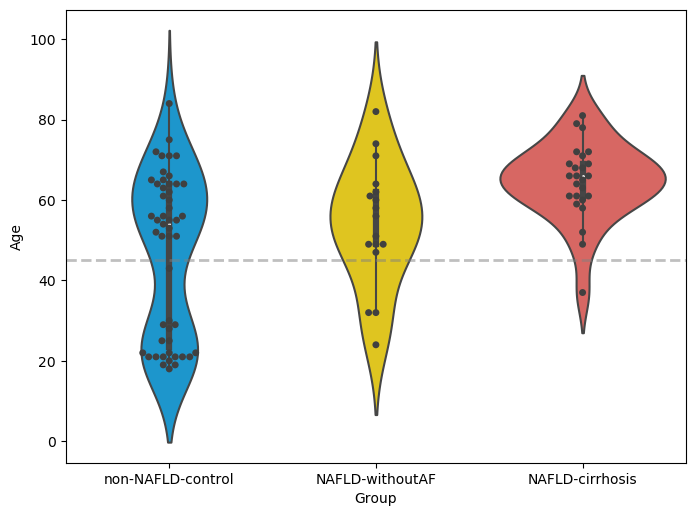

{'NAFLD-cirrhosis', 'NAFLD-withoutAF', 'non-NAFLD-control'}

正常样本： 31
nonAF样本： 14
AF样本： 24


In [10]:
meta = pd.read_csv(META_PATH, index_col=0, sep='\t')
_ = plt.figure(figsize=(8, 6), dpi=100)
_ = sns.violinplot(x="Group", y="Age", data=meta, palette=['#00a1e9', '#ffdc00','#ea5550'],
                   order=['non-NAFLD-control', 'NAFLD-withoutAF', 'NAFLD-cirrhosis'])
_ = sns.swarmplot(x="Group", y="Age", data=meta, color=".25",
                  order=['non-NAFLD-control', 'NAFLD-withoutAF', 'NAFLD-cirrhosis'])
_ = plt.axhline(45, alpha=0.5, color='gray', linestyle='--', lw=2)
_ = plt.show()

meta = meta.loc[meta['Age']>=45, :].loc[meta['Age']<90, :]

DiseaseStatus = meta['Group']
set(DiseaseStatus)
DiseaseStatus = np.array(['Normal' if i == 'non-NAFLD-control' else ('NonAF' if i=='NAFLD-withoutAF' else 'AF') for i in DiseaseStatus])
print('正常样本：', (DiseaseStatus=='Normal').sum())
print('nonAF样本：', (DiseaseStatus=='NonAF').sum())
print('AF样本：', (DiseaseStatus=='AF').sum())

meta = pd.DataFrame(np.array([DiseaseStatus]).T, index = meta.index, columns=['DiseaseStatus'])

raw_count = raw_count.loc[:, meta.index]
raw_abun = raw_abun.loc[:, meta.index]

In [12]:
meta_detail = pd.read_csv(DATA_DIR+'RohitHC.txt', index_col=0, sep='\t')
meta_detail.index = meta_detail['Run']
meta_detail = meta_detail.loc[meta.index, ['alt', 'ast']]
meta_detail['DiseaseStatus'] = meta['DiseaseStatus']

meta_detail.to_csv(DATA_DIR+'RohitHC_validationset.csv')

选取年龄大于45的样本进行后续分析

### 1.3 通过设置的样本覆盖度筛选OTU

In [13]:
sample_cover = (raw_abun>0).sum(1)/float(raw_abun.shape[1])
abun_df = raw_abun.loc[sample_cover >= COVER_RATE, :]
print('样本覆盖度高于'+str(COVER_RATE)+'的OTU一共'+str(abun_df.shape[0])+'个')
abun_df = abun_df.T
count_df = raw_count.loc[sample_cover >= COVER_RATE, :].T
abun_df.head()

样本覆盖度高于0.5的OTU一共190个


#OTU ID,ba9d37124891e5eac8d802723297e54ec38ab03d,bbe2a34c279534c0d745d5189b6e064db7ffe9b8,77f20b8915b46cef9458c74f13e4281822a835d7,27ce7f321d9d8556bbc8f16430c9795b2690a3ea,a0076e37a7d89de1eb15d0a9ebeadabf693b76e1,f319b2de319bd91c97ac339c71a881594b34a156,06a396640fa8a772d19b7a77720980b599f1d178,6c967ed9b68e96299f65615180cf94efaf5f93ec,78db3343e837ab1031f53f7ed44f9e39f790086c,3f254035b84001054a98d6713db494cae883545c,...,242649cefb9a3d66d218b2eb9d5f66594456b8d0,201fe636016e453d9b1d876bcf9c9c81e16126ce,2f3327540661a5b628a103352e2d9731fb7bd13c,524d5509ecc18d29af0bbe333938568425e56dd5,4ff5c5d092eba42696f4dca89b3061f35ce61530,81ff288bda3c6aeb68ae24b265180372959ca74d,7db290f9682e85efafd163b40f4d50d92deb3194,26b6322c365bfcdcc5c06bdda44ee87eebebd3de,fe5cc67bc49e188dd6592eef4f718cfdb21d93c3,f6479b19f128dca30479850ac88ee680e77f5a7d
#SampleID,,,,,,,,,,,,,,,,,,,,,
ERR2753669,0.024324,0.053514,0.017027,0.192163,0.000000,1.958113,0.007297,0.017027,0.019460,0.012162,...,0.060811,0.026757,0.153244,0.000000,0.002432,0.046216,0.000000,0.177568,0.017027,0.116757
ERR2753671,0.050767,0.000000,0.823556,0.022563,0.166403,1.365072,0.039486,0.078971,0.031024,0.039486,...,0.000000,0.025384,1.695059,0.002820,0.025384,0.000000,0.000000,0.005641,0.005641,0.000000
ERR2753673,0.007809,0.799167,0.000000,0.395679,0.124951,0.747104,0.013016,0.000000,0.023428,0.018222,...,0.036444,0.031238,0.736691,0.072888,0.338409,0.015619,0.010413,0.033841,0.190030,0.130157
ERR2753677,0.004969,0.004969,0.002485,0.064603,0.000000,0.017393,0.042240,0.000000,0.059633,0.047210,...,0.144114,0.059633,0.002485,2.400239,0.004969,0.004969,0.009939,0.002485,0.004969,0.032301
ERR2753681,0.000000,0.021019,0.120862,0.000000,0.144509,1.321597,0.031529,0.010510,0.023647,0.044666,...,0.000000,0.026274,0.832895,0.000000,0.002627,0.002627,0.000000,0.000000,0.207567,0.002627


不同状态的年龄分布较为均衡一致，可以进行后续分析

### 1.4 OTU物种注释信息

In [14]:
tax_df = pd.read_csv(TAX_PATH, index_col=0, sep='\t')
tax_df.head()

,Taxon,Confidence
Feature ID,,
00016d6098a9b670e688bb60fcc0f8bc3f6f0f97,D_0__Bacteria;D_1__Bacteroidetes;D_2__Bacteroi...,0.999988
0001e2bf9ec9edaa437a8ce7845b18cb0dd37b57,D_0__Bacteria,0.763089
000274c35abc06c2f931bbb92290fd0888953668,D_0__Bacteria,0.989994
0002de02d1f3498960b064a1453d5adc1fc1fdc1,D_0__Bacteria;D_1__Firmicutes;D_2__Clostridia;...,0.988635
00037f76cdd0127b17c0897d99432a8100b96f53,D_0__Bacteria;D_1__Proteobacteria;D_2__Gammapr...,0.821894


#### 删除未注释（Unassigned）到Class的OTU

In [15]:
assigned_indicate = np.array(['D_3__' in i for i in tax_df.loc[abun_df.columns, 'Taxon']])
abun_df = abun_df.loc[:, assigned_indicate]
count_df = count_df.loc[:, assigned_indicate]
print('处理后，数据中一共'+str(abun_df.shape[0])+'个样本，'+str(abun_df.shape[1])+'个OTU')

处理后，数据中一共69个样本，127个OTU


In [18]:
tax_species = pd.read_csv(DATA_DIR+'RohitNC_dn97_OTU_taxonomy_reassign.csv', index_col=0)
tax_species.head()

,OTU_ID,Tax,Class,Family,NCBI_ID,NCBI_Tax,Species,Abb.
025c3c0b72c2a0391e82ee8845a0b060ea61bbb0,OTU26,D_0__Bacteria;D_1__Bacteroidetes;D_2__Bacteroi...,Bacteroidales,Rikenellaceae,NR_112896.1,Alistipes indistinctus,Alistipes indistinctus(OTU26),A. indistinctus(OTU26)
07df84235f76f8f66d918d96fcd3b9661d3a3a51,OTU12,D_0__Bacteria;D_1__Firmicutes;D_2__Clostridia;...,Clostridiales,Lachnospiraceae,NR_074634.1,[Eubacterium] rectale,Eubacterium rectale(OTU12),E. rectale(OTU12)
0a40c389b2c0ae23f865e444feebf820a9d353e6,OTU19,D_0__Bacteria;D_1__Proteobacteria;D_2__Gammapr...,Enterobacteriales,Enterobacteriaceae,NR_156052.1,Citrobacter europaeus,Citrobacter europaeus,C. europaeus
0aadd7693dfc5e2e04e57b530101f36127951b00,OTU17,D_0__Bacteria;D_1__Firmicutes;D_2__Bacilli;D_3...,Bacillales,None,NR_148626.1,Bacillus cucumis,Bacillus cucumis,B. cucumis
0b876fed0626b041a5ab6564b911a0cd940d455d,OTU57,D_0__Bacteria;D_1__Actinobacteria;D_2__Corioba...,Coriobacteriales,Eggerthellaceae,NR_115868.1,Enterorhabdus caecimuris,Enterorhabdus caecimuris,E. caecimuris


### 1.5 丰度差异菌种

In [19]:
from scipy.stats import ranksums
from statsmodels.stats.multitest import multipletests
def cal_RankSum(data, disease, ds1, ds2, tax, alpha = 0.01):
    res = []
    for i in data.columns:
        value1 = data.loc[disease==ds1, i]
        value2 = data.loc[disease==ds2, i]
        score, pvalue = ranksums(value1, value2)
        fold_change = value2.mean()/float(value1.mean()) if value1.mean() else np.nan
        res.append([i, tax.loc[i, 'Class'], tax.loc[i, 'Family'],tax.loc[i, 'Species'], value1.mean(), value2.mean(), fold_change, score, pvalue])
    res = pd.DataFrame(res, columns=['OTU', 'Class', 'Family', 'Species', ds1, ds2, 'FC', 'RankSum', 'p-value'])
    reject, fdr, _, _ = multipletests(list(res['p-value']), alpha=alpha, method='fdr_bh')
    res['FDR'] = fdr
    res = res.sort_values(by='FDR', ascending=True)
    res.index = range(len(res.index))
    return res

print('### NAFLD-witAF vs Normal:')
AF_vs_Normal = cal_RankSum(abun_df, DiseaseStatus, 'Normal', 'AF', tax_species, alpha = 0.01)
AF_vs_Normal.index = AF_vs_Normal['OTU']
temp = AF_vs_Normal.copy()
temp.index = range(len(temp.index))
temp.head(10)

print('### NAFLD-withoutAF vs Normal:')
NonAF_vs_Normal = cal_RankSum(abun_df, DiseaseStatus, 'Normal', 'NonAF', tax_species, alpha = 0.01)
NonAF_vs_Normal.index = NonAF_vs_Normal['OTU']
temp = NonAF_vs_Normal.copy()
temp.index = range(len(temp.index))
temp.head(10)

print('### NAFLD-withAF vs NAFLD-withoutAF:')
AF_vs_NonAF = cal_RankSum(abun_df, DiseaseStatus, 'NonAF', 'AF', tax_species, alpha = 0.01)
AF_vs_NonAF.index = AF_vs_NonAF['OTU']
temp = AF_vs_NonAF.copy()
temp.index = range(len(temp.index))
temp.head(10)

### NAFLD-witAF vs Normal:


,OTU,Class,Family,Species,Normal,AF,FC,RankSum,p-value,FDR
0,f1ea8d661cc5a8d536ac91ebb62fb64b8b4e3dae,Erysipelotrichales,Erysipelotrichaceae,Erysipelotrichaceae(OTU96),1.256120,0.249762,0.198836,4.972534,6.608337e-07,0.000084
1,f6479b19f128dca30479850ac88ee680e77f5a7d,Clostridiales,Peptostreptococcaceae,Romboutsia lituseburensis,0.494134,0.053833,0.108944,3.309366,9.350764e-04,0.042506
2,c123a770771185e7e43fd102c1e6347e9eb3a2f7,Clostridiales,Lachnospiraceae,Lachnospiraceae(OTU86),0.420583,0.031382,0.074615,3.258452,1.120217e-03,0.042506
3,025c3c0b72c2a0391e82ee8845a0b060ea61bbb0,Bacteroidales,Rikenellaceae,Alistipes indistinctus(OTU26),0.198121,0.024167,0.121981,3.207539,1.338759e-03,0.042506
4,b135b820362617faaa439d6711f945e7e1e08cd6,Clostridiales,Lachnospiraceae,Eubacterium oxidoreducens,0.597286,0.312245,0.522772,2.978429,2.897301e-03,0.051354
5,0b876fed0626b041a5ab6564b911a0cd940d455d,Coriobacteriales,Eggerthellaceae,Enterorhabdus caecimuris,0.007374,0.003482,0.472220,3.037828,2.382900e-03,0.051354
6,8af975f74bdf06d47aaa762096cb2d181f5af001,Clostridiales,Ruminococcaceae,Ruminococcaceae(OTU44),0.157527,0.047002,0.298377,2.952972,3.147301e-03,0.051354
7,07df84235f76f8f66d918d96fcd3b9661d3a3a51,Clostridiales,Lachnospiraceae,Eubacterium rectale(OTU12),0.129226,0.053714,0.415659,2.944487,3.234907e-03,0.051354
8,71779fab49fba8ab4f2d68b74c5a9b70dd48f475,Clostridiales,Ruminococcaceae,Oscillibacter valericigenes,0.085558,0.011644,0.136096,2.783261,5.381544e-03,0.068346
9,5c3307470a80cc114615671dde3c6958e3de89de,Clostridiales,Lachnospiraceae,Roseburia hominis(OTU106),0.475830,0.028396,0.059676,2.800232,5.106582e-03,0.068346


### NAFLD-withoutAF vs Normal:


,OTU,Class,Family,Species,Normal,NonAF,FC,RankSum,p-value,FDR
0,49ab52c9da5c10c5c05969f6a72a91a1c6c8bc65,Clostridiales,Ruminococcaceae,Ruminiclostridium hungatei(OTU63),0.352099,0.002351,0.006677,2.893003,0.003816,0.278224
1,d3379224de8a6ad25d0f135fe666cfd0a8ce554e,Bacteroidales,Tannerellaceae,Parabacteroides chartae(OTU70),0.479671,0.057921,0.120752,2.304595,0.021189,0.278224
2,60661167d1f8deb1c31542a83c3a59f364508501,Clostridiales,Ruminococcaceae,Ruminococcaceae(OTU74),0.143535,0.014454,0.100703,2.280078,0.022603,0.278224
3,97b18743ced53a3753fb858108fefb8a9ba036bd,Clostridiales,Lachnospiraceae,Ruminococcus lactaris(OTU83),0.317700,0.167339,0.526722,2.439439,0.014710,0.278224
4,40534050235d816268f98a1aca56cde478e66a00,Bifidobacteriales,Bifidobacteriaceae,Bifidobacterium magnum,0.839229,1.979914,2.359205,-2.378146,0.017400,0.278224
5,025c3c0b72c2a0391e82ee8845a0b060ea61bbb0,Bacteroidales,Rikenellaceae,Alistipes indistinctus(OTU26),0.198121,0.012174,0.061446,2.378146,0.017400,0.278224
6,9e5551b92019ab14f7339e0924c8d88f5ead5cc0,Clostridiales,Ruminococcaceae,Ruminococcaceae(OTU25),0.171148,0.024676,0.144179,2.329112,0.019853,0.278224
7,c2a7b89a736f924b4c68f4043efa8e4d05c45708,Clostridiales,Peptostreptococcaceae,Intestinibacter bartlettii,0.106474,0.171248,1.608360,-2.402663,0.016276,0.278224
8,07df84235f76f8f66d918d96fcd3b9661d3a3a51,Clostridiales,Lachnospiraceae,Eubacterium rectale(OTU12),0.129226,0.005262,0.040720,2.365888,0.017987,0.278224
9,c3162b02a2d3d97d9772108c246fd56c81ef1275,Bacillales,Bacillaceae,Oceanobacillus jeddahense,0.775230,5.871094,7.573358,-2.255561,0.024098,0.278224


### NAFLD-withAF vs NAFLD-withoutAF:


,OTU,Class,Family,Species,NonAF,AF,FC,RankSum,p-value,FDR
0,f6479b19f128dca30479850ac88ee680e77f5a7d,Clostridiales,Peptostreptococcaceae,Romboutsia lituseburensis,1.022657,0.053833,0.052640,3.328751,0.000872,0.055395
1,f1ea8d661cc5a8d536ac91ebb62fb64b8b4e3dae,Erysipelotrichales,Erysipelotrichaceae,Erysipelotrichaceae(OTU96),1.039116,0.249762,0.240360,3.434666,0.000593,0.055395
2,c3162b02a2d3d97d9772108c246fd56c81ef1275,Bacillales,Bacillaceae,Oceanobacillus jeddahense,5.871094,0.359377,0.061211,2.693263,0.007076,0.179280
3,f319b2de319bd91c97ac339c71a881594b34a156,Clostridiales,Lachnospiraceae,Dorea longicatena,1.595876,0.631421,0.395658,2.632740,0.008470,0.179280
4,0a40c389b2c0ae23f865e444feebf820a9d353e6,Enterobacteriales,Enterobacteriaceae,Citrobacter europaeus,0.028685,2.522165,87.927584,-2.693263,0.007076,0.179280
5,c2a7b89a736f924b4c68f4043efa8e4d05c45708,Clostridiales,Peptostreptococcaceae,Intestinibacter bartlettii,0.171248,0.107058,0.625163,2.632740,0.008470,0.179280
6,7e3f625115c48cf9721e9ffe63b3c48b5149ba18,Enterobacteriales,Enterobacteriaceae,Escherichia-Shigella(OTU72),12.447345,20.859639,1.675830,-2.269603,0.023232,0.421489
7,f152e68345172c4c0bd43c66dedf60acdd99fb72,Clostridiales,Clostridiaceae 1,Clostridium autoethanogenum,0.484040,0.159816,0.330172,2.209080,0.027169,0.431309
8,97b18743ced53a3753fb858108fefb8a9ba036bd,Clostridiales,Lachnospiraceae,Ruminococcus lactaris(OTU83),0.167339,0.381851,2.281896,-2.027512,0.042610,0.467569
9,f0da08923004a661f9c5980dbfe67306f05e301a,Clostridiales,Lachnospiraceae,Lachnospiraceae(OTU68),0.345279,0.053229,0.154163,2.012382,0.044180,0.467569


* 和Discovery数据类似的，Clostridiales(梭菌目)是主要出现差异表达的菌种Class，其中Lachnospiraceae(毛螺菌科)和Ruminococcaceae(瘤胃菌科)同样差异显著下调；
* NAFLD-withAF相对于Normal比NAFLD-withoutAF的菌种丰度差异更加明显，但差异显著性不如Discovery青少年数据；
* 与青少年中Obese和NASH不同的，NAFLD-withAF和NAFLD-withoutAF的菌种有较大差别；
* 由于FDR显著性较差，因此后续分析主要基于p-value

In [260]:
AF_vs_Normal.to_csv(CAUSAL_PATH+'AF_vs_Normal_DE.csv')
NonAF_vs_Normal.to_csv(CAUSAL_PATH+'NonAF_vs_Normal_DE.csv')
AF_vs_NonAF.to_csv(CAUSAL_PATH+'AF_vs_NonAF_DE.csv')

### 1.6 差异菌种变化情况-bar图（AF vs Normal中 p-value<0.01的菌种进行分析）

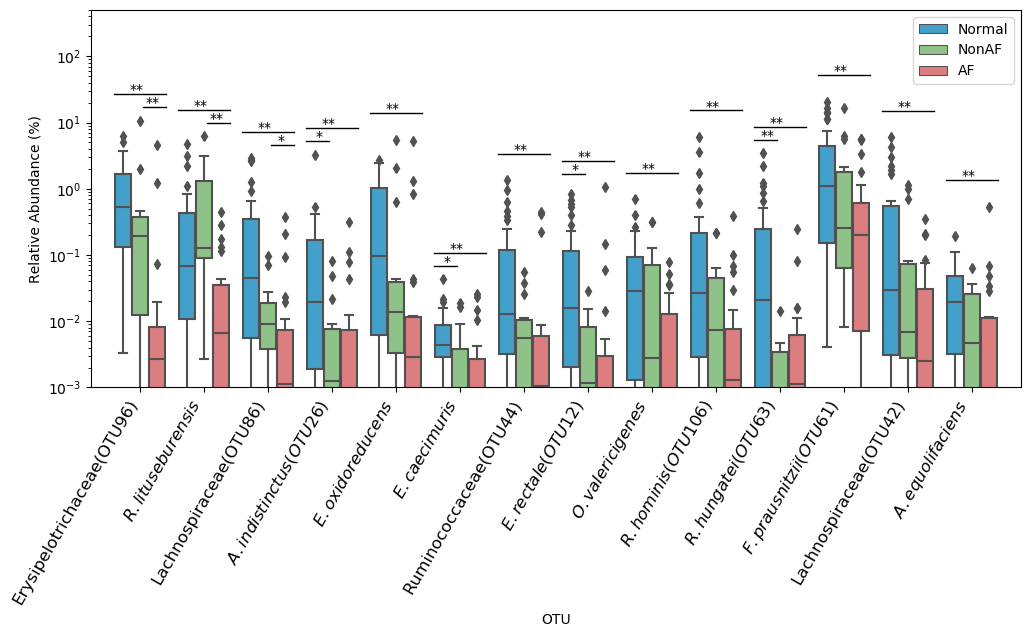

In [21]:
DEOTU = AF_vs_Normal.loc[AF_vs_Normal['p-value']<0.01, 'OTU']
res_plot = []
for otu in DEOTU:
    for d in ['Normal', 'NonAF', 'AF']:
        for i in abun_df.loc[DiseaseStatus==d, otu]:
            res_plot.append([otu, tax_df.loc[otu, 'Taxon'], d, i])
res_plot = pd.DataFrame(res_plot, columns=['OTU', 'Taxon', 'State', 'Abundance'])
_ = plt.figure(figsize=(12, 5), dpi=100)
p = sns.boxplot(x="OTU", y="Abundance", hue="State", data=res_plot, palette=['#2ca9e1', '#88cb7f', '#ec6d71'])
######
import matplotlib.lines as mlines
i = 0
for otu in DEOTU:
    max_value = res_plot.loc[res_plot['OTU']==otu, 'Abundance'].max()
    if NonAF_vs_Normal.loc[otu, 'p-value']<=0.05:
        x, y = np.array([[i-0.4, i-0.05], [max_value*1.6, max_value*1.6]])
        l = mlines.Line2D(x, y, lw=1., c='k')
        _ = p.add_line(l)
        _ = plt.text(i-0.2, max_value*1.6, '**' if NonAF_vs_Normal.loc[otu, 'p-value']<=0.01 else '*',
                     ha="center", size=10)
        
    if AF_vs_NonAF.loc[otu, 'p-value']<=0.05:
        x, y = np.array([[i+0.05, i+0.4], [max_value*1.6, max_value*1.6]])
        l = mlines.Line2D(x, y, lw=1., c='k')
        _ = p.add_line(l)
        _ = plt.text(i+0.2, max_value*1.6, '**' if AF_vs_NonAF.loc[otu, 'p-value']<=0.01 else '*',
                     ha="center", size=10)
        
    if AF_vs_Normal.loc[otu, 'p-value']<=0.05:
        x, y = np.array([[i-0.4, i+0.4], [max_value*2.5, max_value*2.5]])
        l = mlines.Line2D(x, y, lw=1., c='k')
        _ = p.add_line(l)
        _ = plt.text(i-0.05, max_value*2.5, '**' if AF_vs_Normal.loc[otu, 'p-value']<=0.01 else '*',
                     ha="center", size=10)
    i += 1  
#######   
_ = plt.ylim([10**(-3), 500])
_ = plt.semilogy()
_ = plt.xticks(range(len(DEOTU)), 
               ['$'+tax_species.loc[otu, 'Abb.']+'$' if '.' in tax_species.loc[otu, 'Abb.'] else tax_species.loc[otu, 'Abb.'] for otu in DEOTU], 
               rotation=60, ha='right', fontsize=12)
_ = plt.legend(loc='upper right')
_ = plt.ylabel('Relative Abundance (%)')
_ = plt.show()

* NAFLD-withAF对Normal显著差异的14个菌种(p-value<0.01)，部分菌种在NAFLD-withoutAF中也出现显著差异; 部分菌种在NAFLD-withAF和NAFLD-withoutAF中丰度差异变化；
* 与Discovery数据类似，除了Peptostreptococcaceae外，菌种丰度在 Normal - withoutAF - AF 不同状态中呈现阶梯式的变化的趋势，表明AF比withoutAF菌种变化更加强烈，并且显著差异菌种都是丰度下调；
* 与Discovery数据类似，Lachnospiraceae和Ruminococcaceae两个Family菌种在疾病中都统一显著下调，但未发现Family XI中菌种差异上调；

### 1.7 差异菌种变化情况-热图（选取AF vs Normal中 p-value<0.01的菌种进行分析）

(14, 0)

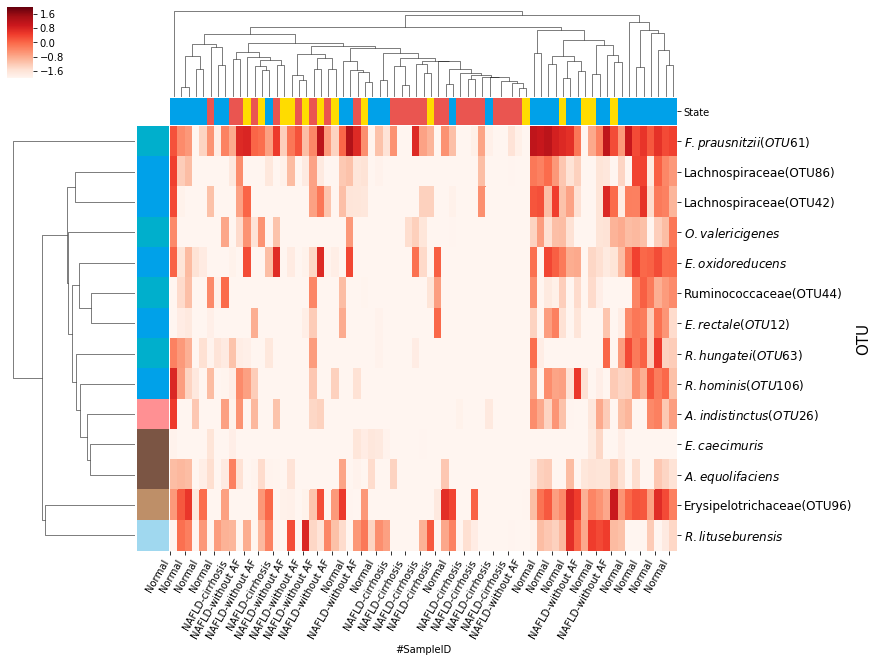

In [24]:
DEOTU = AF_vs_Normal.loc[AF_vs_Normal['p-value']<0.01, 'OTU']
hearmap_data = abun_df.loc[:, DEOTU].T

color = {'Normal':'#00a1e9', 'NonAF':'#ffdc00', 'AF':'#ea5550',
        'Family XI':'#0075c2', 'Ruminococcaceae':'#00afcc', 'Lachnospiraceae':'#00a1e9', 'Peptostreptococcaceae':'#a0d8ef', # Clostridiales
         'Veillonellaceae':'#fcc800', # Selenomonadales
         'Prevotellaceae':'#ed6d46', 'Rikenellaceae':'#ff9093', # Bacteroidales
         'Leuconostocaceae':'#79c06e', # Lactobacillales
         'Eggerthellaceae' : '#7b5544',
         'Erysipelotrichaceae':'#be8f68'
        }

col_colors = pd.Series(data=[color[meta.loc[i, 'DiseaseStatus']] for i in hearmap_data.columns],
                       index=hearmap_data.columns, name='State')

index = ['$'+tax_species.loc[otu, 'Abb.']+'$' if '.' in tax_species.loc[otu, 'Abb.'] else tax_species.loc[otu, 'Abb.'] for otu in DEOTU]
row_colors = [color[tax_species.loc[otu, 'Family']] for otu in DEOTU]
columns = [meta.loc[i, 'DiseaseStatus'] for i in hearmap_data.columns]
columns = ['NAFLD-without AF' if i=='NonAF' else ('NAFLD-cirrhosis' if i=='AF' else 'Normal') for i in columns]
hearmap_data = pd.DataFrame(np.log10(hearmap_data+10**(-10)), index=hearmap_data.index,
                            columns=hearmap_data.columns)
g = sns.clustermap(hearmap_data, cmap="Reds", vmin=-2, vmax=2, row_cluster=True, col_cluster=True,
                   col_colors=col_colors, row_colors=row_colors, figsize=(12, 10), metric='braycurtis')

g.ax_heatmap.axes.set_ylim([14, 0])
#_ = g.ax_heatmap.axes.set_xticks([])
_ = g.ax_heatmap.axes.set_xticks(range(len(columns))[::2])
_ = g.ax_heatmap.axes.set_xticklabels(np.array(columns)[g.dendrogram_col.reordered_ind][::2], fontsize=10, rotation=60, ha='right')
_ = g.ax_heatmap.axes.set_yticklabels(np.array(index)[g.dendrogram_row.reordered_ind], fontsize=12)
_ = g.ax_heatmap.axes.set_ylabel('OTU', fontsize=15)

* 在显著差异菌种中，Normal(蓝色)，AF(红色)呈现明显不同，withoutAF(绿色)；
* 与Discovery数据类似，Lachnospiraceae和Ruminococcaceae两个Family菌种在疾病中都统一显著下调
* 但未发现Family XI中菌种显著上调；

### 1.8 单OTU疾病状态分类模型（选取AF vs Normal中 p-value<0.01的菌种进行分析）

f1ea8d661cc5a8d536ac91ebb62fb64b8b4e3dae Erysipelotrichaceae 0.631336405529954 0.8938172043010753 0.8377976190476191
f6479b19f128dca30479850ac88ee680e77f5a7d Peptostreptococcaceae 0.6175115207373272 0.7620967741935484 0.8273809523809523
c123a770771185e7e43fd102c1e6347e9eb3a2f7 Lachnospiraceae 0.6728110599078341 0.7580645161290323 0.7023809523809523
025c3c0b72c2a0391e82ee8845a0b060ea61bbb0 Rikenellaceae 0.7235023041474654 0.7540322580645162 0.5595238095238094
b135b820362617faaa439d6711f945e7e1e08cd6 Lachnospiraceae 0.6267281105990784 0.7358870967741935 0.6755952380952381
0b876fed0626b041a5ab6564b911a0cd940d455d Eggerthellaceae 0.7050691244239632 0.7405913978494625 0.53125
8af975f74bdf06d47aaa762096cb2d181f5af001 Ruminococcaceae 0.6589861751152074 0.7338709677419355 0.6220238095238095
07df84235f76f8f66d918d96fcd3b9661d3a3a51 Lachnospiraceae 0.7223502304147466 0.7331989247311828 0.5610119047619048
71779fab49fba8ab4f2d68b74c5a9b70dd48f475 Ruminococcaceae 0.6059907834101382 0.72043010752688

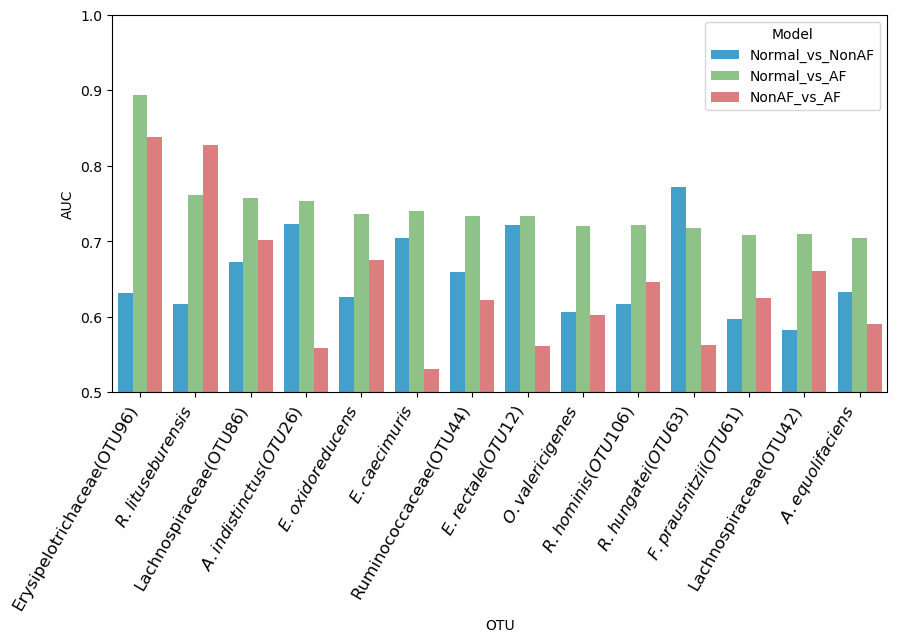

In [25]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
DEOTU = AF_vs_Normal.loc[AF_vs_Normal['p-value']<0.01, 'OTU']
dieases = DiseaseStatus
res = []
for otu in DEOTU:
    # Normal vs Obese
    X = abun_df.loc[dieases!='AF', otu]
    y = (dieases[dieases!='AF']=='NonAF')+0
    auc1 = max([roc_auc_score(y, X), roc_auc_score(y, -X)])
    res.append([otu, tax_df.loc[otu, 'Taxon'], 'Normal_vs_NonAF', auc1])
    # Normal vs NASH
    X = abun_df.loc[dieases!='NonAF', otu]
    y = (dieases[dieases!='NonAF']=='AF')+0
    auc2 = max([roc_auc_score(y, X), roc_auc_score(y, -X)])
    res.append([otu, tax_df.loc[otu, 'Taxon'], 'Normal_vs_AF', auc2])
    # Obese vs NASH
    X = abun_df.loc[dieases!='Normal', otu]
    y = (dieases[dieases!='Normal']=='AF')+0
    auc3 = max([roc_auc_score(y, X), roc_auc_score(y, -X)])
    res.append([otu, tax_df.loc[otu, 'Taxon'], 'NonAF_vs_AF', auc3])
    print(otu, tax_species.loc[otu, 'Family'], auc1, auc2, auc3)
res = pd.DataFrame(res, columns=['OTU', 'Tax', 'Model', 'AUC'])

_ = plt.figure(figsize=(10, 5), dpi=100)
_ = sns.barplot(x="OTU", y="AUC", hue="Model", data=res, palette=['#2ca9e1', '#88cb7f', '#ec6d71'])
_ = plt.ylim((0.5, 1))
_ = plt.xticks(range(len(DEOTU)), 
               ['$'+tax_species.loc[otu, 'Abb.']+'$' if '.' in tax_species.loc[otu, 'Abb.'] else tax_species.loc[otu, 'Abb.'] for otu in DEOTU]
               , rotation=60, ha='right', fontsize=12)


* 差异菌种在样本分辨能力上效果也不错；
* 最显著差异的两个菌Erysipelotrichaceae和Peptostreptococcaceae具有较强的分辨能力，并且对于withoutAF和AF两个状态的病人也有着较好的分辨能力；

## 总结

* Normal到withoutAF到AF差异菌种也呈现逐步差异变化，但withoutAF和AF也具有较多不同；
* 与青少年相同，Clostridiales是主要出现差异表达的菌种Class，该Class中Lachnospiraceae和Ruminococcaceae两个Family的菌种统一显著下调，但未发现Family XI差异显著上调；

# 2. 菌种相互作用和关键菌种

In [70]:
### 输出丰度信息，用于计算相互作用
#abun_df.T.to_csv(DATA_DIR+'abun_df.csv', sep='\t')
#abun_df.loc[DiseaseStatus=='Normal', :].T.to_csv(DATA_DIR+'abun_df_normal.csv', sep='\t')
#abun_df.loc[DiseaseStatus=='NonAF', :].T.to_csv(DATA_DIR+'abun_df_nonaf.csv', sep='\t')
#abun_df.loc[DiseaseStatus=='AF', :].T.to_csv(DATA_DIR+'abun_df_af.csv', sep='\t')
#count_df.T.to_csv(DATA_DIR+'counts_df.csv', sep='\t')
#count_df.loc[DiseaseStatus=='Normal', :].T.to_csv(DATA_DIR+'counts_df_normal.csv', sep='\t')
#count_df.loc[DiseaseStatus=='NonAF', :].T.to_csv(DATA_DIR+'counts_df_nonaf.csv', sep='\t')
#count_df.loc[DiseaseStatus=='AF', :].T.to_csv(DATA_DIR+'counts_df_af.csv', sep='\t')

### 2.1 计算相互作用关系

sparcc --> dowhy

In [71]:
# using python2.7; numpy == 1.10.1
# sparcc core_methods.py (to_fractions):
# line 298 --> DF(np.array(list(fracs)), index=frame.index, columns=frame.columns)
# https://bitbucket.org/yonatanf/sparcc/src/default/
# python '/Users/dingfengwu/Desktop/NAFLD3/run_sparcc.py'

# using python3.6 dowhy
# python '/Users/dingfengwu/Desktop/NAFLD3/run_causalinference.py'

### 2.2 菌种相互作用网络

#### 2.2.1 OTU相互作用关系热图

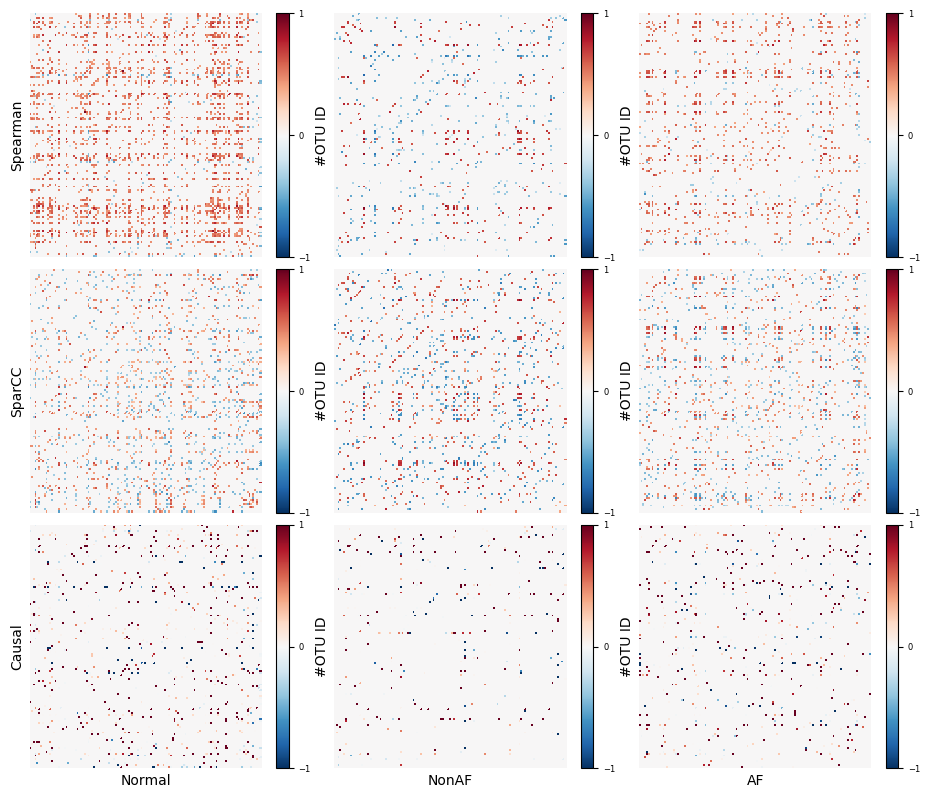

In [72]:
plot_disease = ['Normal', 'NonAF', 'AF']
plot_method = ['Spearman', 'SparCC', 'Causal']

_ = plt.figure(figsize=(10, 10), dpi=100)
gs = gridspec.GridSpec(3, 3)
gs.update(left=0.05, right=0.95, wspace=0.05, hspace=0.05)
r = 0
for m in plot_method:
    c = 0
    for d in plot_disease:
        ax = plt.subplot(gs[r, c])
        if m.lower() == 'causal':
            relation = pd.read_csv(CAUSAL_PATH+'abun_df_'+d.lower()+'_'+m.lower()+'_final.csv', index_col=0, sep=',')
            p_value = pd.read_csv(CAUSAL_PATH+'abun_df_'+d.lower()+'_'+m.lower()+'_p_one_sided_final.csv', index_col=0, sep=',')
            prior = 1-pd.read_csv(CAUSAL_PATH+'abun_df_'+d.lower()+'_'+m.lower()+'_p_one_sided.csv', index_col=0, sep=',')
        else:
            relation = pd.read_csv(SPARCC_PATH+'counts_df_'+d.lower()+'_'+m.lower()+'.csv', index_col=0, sep='\t')
            p_value = pd.read_csv(SPARCC_PATH+'counts_df_'+d.lower()+'_'+m.lower()+'_p_one_sided.csv', index_col=0, sep='\t')
            prior = np.ones(p_value.shape)
        
        relation *= (p_value<=INTERACTION_P_THRESHOLD)&(prior>=PRIOR_THRESHOLD)
        subplot = sns.heatmap(relation, mask=None, cmap="RdBu_r", vmin=-1, vmax=1, cbar=False, annot=False,
                              fmt='.1g', annot_kws={'fontsize':5}, cbar_kws={'fontsize':5},
                              linewidths=0.0, xticklabels=True, yticklabels=True)
        cb = subplot.figure.colorbar(subplot.collections[0], ticks=[-1, 0, 1]) #显示colorbar
        _ = cb.ax.tick_params(labelsize=6) #设置colorbar刻度字体大小
        _ = subplot.tick_params(axis='both', which='both', labelsize=6, length=4, width=0, pad=0)
        if r < 2:
            _ = subplot.set_xticks([])
        if c > 0:
            _ = subplot.set_yticks([])
        ###
        _ = subplot.set_xticks([])
        _ = subplot.set_yticks([])
        ###
        if c == 0:
            _ = subplot.set_ylabel(m)
        if r == 2:
            _ = subplot.set_xlabel(d)
        c += 1
    r += 1

* 同样地，Causal方法推理的相互作用较为稀疏，比较符合真实情况；

#### 2.2.2. 相互作用Scale-free性质（幂律分布）

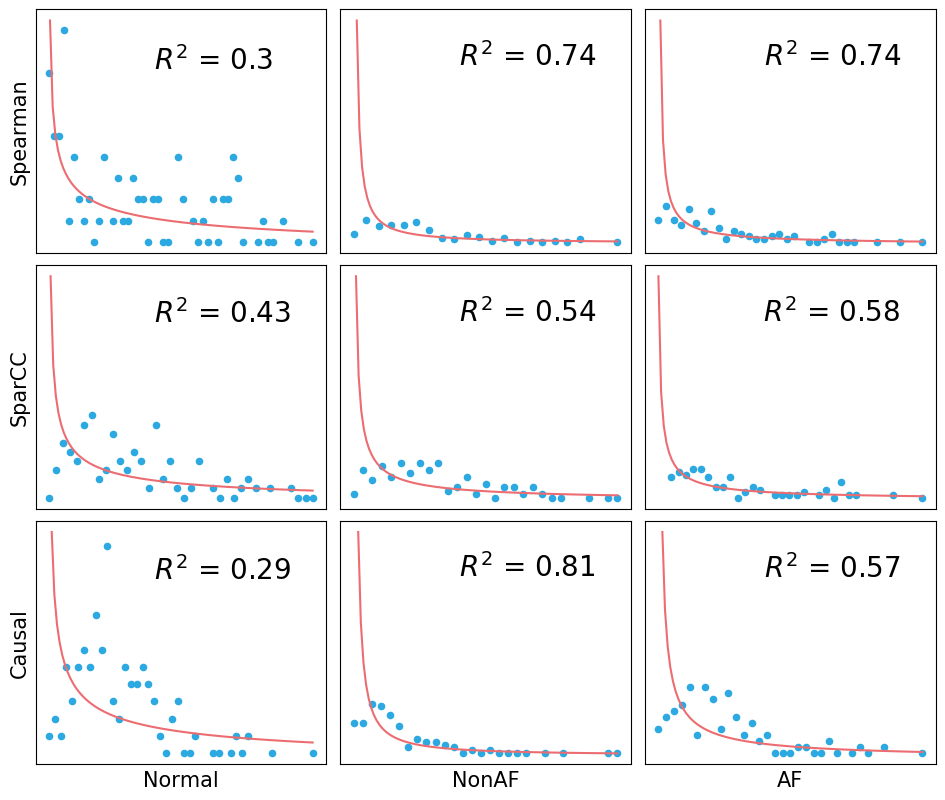

In [73]:
import statsmodels.api as sm
def powlaw_fiting(d, m):
    if m.lower() == 'causal':
        relation = pd.read_csv(CAUSAL_PATH+'abun_df_'+d.lower()+'_'+m.lower()+'_final.csv', index_col=0, sep=',')
        p_value = pd.read_csv(CAUSAL_PATH+'abun_df_'+d.lower()+'_'+m.lower()+'_p_one_sided_final.csv', index_col=0, sep=',')
        prior = 1-pd.read_csv(CAUSAL_PATH+'abun_df_'+d.lower()+'_'+m.lower()+'_p_one_sided.csv', index_col=0, sep=',')
    else:
        relation = pd.read_csv(SPARCC_PATH+'counts_df_'+d.lower()+'_'+m.lower()+'.csv', index_col=0, sep='\t')
        p_value = pd.read_csv(SPARCC_PATH+'counts_df_'+d.lower()+'_'+m.lower()+'_p_one_sided.csv', index_col=0, sep='\t')
        prior = np.ones(p_value.shape)
    relation *= (p_value<=INTERACTION_P_THRESHOLD)&(prior>=PRIOR_THRESHOLD)
    degree = (relation!=0).sum().sum()
    res = {}
    for i in relation.columns:
        N = (relation[i]!=0).sum() + (relation.loc[i, :]!=0).sum()
        res[N] = res.get(N, 0) + 1
    X = []
    y = []
    for i, j in res.items():
        if i != 0:
            X.append([np.log10(i)])
            y.append(np.log10(j))
    X = np.array(X)
    X = sm.add_constant(X)
    ols = sm.OLS(y, X).fit()
    a = 10**ols.params[0]
    b = ols.params[1]
    yfunc = lambda x:a*(x**b)
    X_pred = np.linspace(0.5, max(res.keys()), 100)
    y_pred = [yfunc(i) for i in X_pred]
    return res, X_pred, y_pred, ols.rsquared

plot_disease = ['Normal', 'NonAF', 'AF']
plot_method = ['Spearman', 'SparCC', 'Causal']

fig = plt.figure(figsize=(10, 10), dpi=100)
gs = gridspec.GridSpec(3, 3)
gs.update(left=0.05, right=0.95, wspace=0.05, hspace=0.05)

r = 0
for m in plot_method:
    c = 0
    for d in plot_disease:
        ax = plt.subplot(gs[r, c])
        degree, X_pred, y_pred, rsquared = powlaw_fiting(d, m)
        _ = plt.scatter(degree.keys(), degree.values(), color='#2ca9e1', s=20)
        _ = plt.plot(X_pred, y_pred, 'r-', label="Powlaw distribution fitting", color='#ec6d71')
        _ = plt.annotate('$R^2$ = '+str(round(rsquared, 2)),
                     xy=(max(X_pred)*0.4, max([max(y_pred), max(degree.values())])*0.8), fontsize=20)
        _ = ax.set_xticks([])
        _ = ax.set_yticks([])
        ###
        if c == 0:
            _ = ax.set_ylabel(m, fontsize=15)
        if r == 2:
            _ = ax.set_xlabel(d, fontsize=15)
        c += 1
    r += 1
    #plt.xlabel('Degree')
    #plt.ylabel('Number of Nodes')

Normal状态网络结构反而没有scale-free，可能是Normal样本菌种变化较大，NonAF状态菌群相互作用scale-free性质最为明显；

#### 2.2.3 菌种相互作用网络

In [77]:
def getFamily_Genus(tax):
    family = re.search(r'D_4__(.+?);', tax.strip()+';')
    genus = re.search(r'D_5__(.+?);', tax.strip()+';')
    family = family.group(1) if family else 'None'
    genus = genus.group(1) if genus else 'None'
    return family, genus

plot_disease = ['Normal', 'NonAF', 'AF']
for d in plot_disease:
    relation = pd.read_csv(CAUSAL_PATH+'abun_df_'+d.lower()+'_causal_final.csv', index_col=0, sep=',')
    p_value = pd.read_csv(CAUSAL_PATH+'abun_df_'+d.lower()+'_causal_p_one_sided_final.csv', index_col=0, sep=',')
    prior = 1-pd.read_csv(CAUSAL_PATH+'abun_df_'+d.lower()+'_causal_p_one_sided.csv', index_col=0, sep=',')
    
    links = []
    nodes = []
    for i in relation.index:
        for j in relation.columns:
            if p_value.loc[i, j]<=INTERACTION_P_THRESHOLD and prior.loc[i, j]>=PRIOR_THRESHOLD:
                links.append([j, i, relation.loc[i, j], abs(relation.loc[i, j]), 1 if relation.loc[i, j]>0 else 0])
        f, g = getFamily_Genus(tax_df.loc[i, 'Taxon'])
        nodes.append([i, tax_df.loc[i, 'Taxon'], f, g])
    links = pd.DataFrame(links, columns=['Source', 'Target', 'w', 'abs_w', 'direction'])
    nodes = pd.DataFrame(nodes, columns=['OTU', 'Tax', 'Family', 'Genus'])
    links.to_csv(CAUSAL_PATH+'Network/'+d+'_links.csv')
    nodes.to_csv(CAUSAL_PATH+'Network/'+d+'_nodes.csv')

利用Cytoscape绘制不同状态菌种相互作用网络 （节点大小由Out-degree大小进行标注）

<div align="center">
<img src="Image/Rohit_Normal_raw.png" width="33%" style='float:left'/>
<img src="Image/Rohit_NonAF_raw.png" width="33%" style='float:left'/>
<img src="Image/Rohit_AF_raw.png" width="33%" style='float:left'/>
</div>

* 成年人数据由于测的更深，出现较多青少年中较少的菌种(灰色)，Lachnospiraceae（蓝色）仍旧是一类重要的网络调控菌种；

#### 2.2.4 网络拓扑统计

In [78]:
def getFamily_Genus(tax):
    family = re.search(r'D_4__(.+?);', tax.strip()+';')
    genus = re.search(r'D_5__(.+?);', tax.strip()+';')
    family = family.group(1) if family else 'None'
    genus = genus.group(1) if genus else 'None'
    return family, genus

plot_disease = ['Normal', 'NonAF', 'AF']
res = []
family_links = {'Normal':{}, 'NonAF':{}, 'AF':{}}
degrees = {}
m = 'causal'
for d in plot_disease:
    relation = pd.read_csv(CAUSAL_PATH+'abun_df_'+d.lower()+'_'+m.lower()+'_final.csv', index_col=0, sep=',')
    p_value = pd.read_csv(CAUSAL_PATH+'abun_df_'+d.lower()+'_'+m.lower()+'_p_one_sided_final.csv', index_col=0, sep=',')
    prior = 1-pd.read_csv(CAUSAL_PATH+'abun_df_'+d.lower()+'_'+m.lower()+'_p_one_sided.csv', index_col=0, sep=',')
    
    relation *= (p_value<=INTERACTION_P_THRESHOLD)&(prior>=PRIOR_THRESHOLD)
    degree = (relation!=0).sum().sum()
    degrees[d] = degree
    pos_degree = (relation>0).sum().sum()
    neg_degree = (relation<0).sum().sum()
    res.append([degree, pos_degree, neg_degree, pos_degree/float(neg_degree)])
    for i in relation.columns:
        f, g = getFamily_Genus(tax_df.loc[i, 'Taxon'])
        family_links[d][f] = family_links[d].get(f, 0) + (relation[i]!=0).sum()
res = pd.DataFrame(res, index=plot_disease, columns=['Degree', 'Positive', 'Negative', 'Pos/Neg'])
res
### Family
families = [i[0] for i in sorted(family_links['Normal'].items(), key=lambda x:x[1], reverse=True)]
res = []
for f in families:
    res.append([family_links['Normal'][f], family_links['NonAF'][f], family_links['AF'][f],
               (family_links['NonAF'][f]/float(degrees['NonAF']))/(family_links['Normal'][f]/float(degrees['Normal'])),
               (family_links['AF'][f]/float(degrees['AF']))/(family_links['Normal'][f]/float(degrees['Normal'])),
               (family_links['AF'][f]/float(degrees['AF']))/(family_links['NonAF'][f]/float(degrees['NonAF']))])
res = pd.DataFrame(res, index=families, columns=['Normal', 'NonAF', 'AF', 'Odd_NonAF vs Normal', 'Odd_AF vs Normal', 'Odd_AF vs NonAF'])
res

,Degree,Positive,Negative,Pos/Neg
Normal,809,575,234,2.457265
NonAF,345,228,117,1.948718
AF,564,392,172,2.279070


/Users/dingfengwu/anaconda3/envs/ai2019/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in double_scalars
/Users/dingfengwu/anaconda3/envs/ai2019/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: divide by zero encountered in double_scalars
/Users/dingfengwu/anaconda3/envs/ai2019/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in double_scalars
/Users/dingfengwu/anaconda3/envs/ai2019/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in double_scalars


,Normal,NonAF,AF,Odd_NonAF vs Normal,Odd_AF vs Normal,Odd_AF vs NonAF
Lachnospiraceae,364,133,271,0.856800,1.067917,1.246401
Ruminococcaceae,125,65,106,1.219362,1.216369,0.997545
Bacteroidaceae,59,41,40,1.629526,0.972473,0.596783
Erysipelotrichaceae,34,13,9,0.896590,0.379693,0.423486
Peptostreptococcaceae,30,4,10,0.312657,0.478132,1.529255
Enterococcaceae,22,2,4,0.213175,0.260799,1.223404
Eggerthellaceae,21,8,14,0.893306,0.956265,1.070479
Rikenellaceae,17,6,3,0.827621,0.253129,0.305851
Streptococcaceae,16,8,12,1.172464,1.075798,0.917553
Enterobacteriaceae,14,1,10,0.167495,1.024569,6.117021


* Lachnospiraceae，Bacteroidaceae和Ruminococcaceae仍旧是主要影响其他菌种的Family；
* 与青少年相同的，Veillonellaceae等在Obese和NASH中调控作用都明显增加，Prevotellaceae调控作用特异增加，但Burkholderiaceae调控作用作用反而减少；
* 此外，Erysipelotrichaceae，Peptostreptococcaceae，Enterococcaceae等菌种调控作用出现降低；

### 2.3. 相互作用网络菌种重要性和干预分析

#### 2.3.1 HITS网络节点重要性分析

In [12]:
from scipy.stats import ranksums
from statsmodels.stats.multitest import multipletests
def cal_RankSum(data, disease, ds1, ds2, tax, alpha = 0.01):
    res = []
    for i in data.columns:
        value1 = data.loc[disease==ds1, i]
        value2 = data.loc[disease==ds2, i]
        score, pvalue = ranksums(value1, value2)
        fold_change = value2.mean()/float(value1.mean()) if value1.mean() else np.nan
        res.append([i, tax.loc[i, 'Class'], tax.loc[i, 'Family'],tax.loc[i, 'Species'], value1.mean(), value2.mean(), fold_change, score, pvalue])
    res = pd.DataFrame(res, columns=['OTU', 'Class', 'Family', 'Species', ds1, ds2, 'FC', 'RankSum', 'p-value'])
    reject, fdr, _, _ = multipletests(list(res['p-value']), alpha=alpha, method='fdr_bh')
    res['FDR'] = fdr
    res = res.sort_values(by='FDR', ascending=True)
    res.index = range(len(res.index))
    return res

def build_Network(disease):
    relation = pd.read_csv(CAUSAL_PATH+'abun_df_'+disease.lower()+'_causal_final.csv', index_col=0, sep=',')
    p_value = pd.read_csv(CAUSAL_PATH+'abun_df_'+disease.lower()+'_causal_p_one_sided_final.csv', index_col=0, sep=',')
    prior = 1-pd.read_csv(CAUSAL_PATH+'abun_df_'+disease.lower()+'_causal_p_one_sided.csv', index_col=0, sep=',')
    
    edges = []
    nodes = []
    for target in relation.index:
        nodes.append(target)
        for source in relation.columns:
            if p_value.loc[target, source]<=INTERACTION_P_THRESHOLD and prior.loc[target, source]>=PRIOR_THRESHOLD:
                effect = 1.0 #1.0, abs(float(relation.loc[target, source]))
                edges.append((source, target, effect))
    DG=nx.DiGraph()
    DG.add_nodes_from(nodes)
    DG.add_weighted_edges_from(edges)
    return DG

def random_Network(net):
    nodeset = list(net.nodes)
    redges = np.array([(i, j, float(v)) for i,j,v in net.edges.data('weight')])
    redges[:, 0] = [random.choice(nodeset) for i in range(len(redges))]
    redges[:, 1] = [random.choice(nodeset) for i in range(len(redges))]
    redges = [(i, j, float(v)) for i,j,v in redges]
    rnet = nx.DiGraph()
    rnet.add_nodes_from(nodeset)
    rnet.add_weighted_edges_from(redges)
    return rnet

def cal_HITS(net):
    h,a = nx.hits(net, max_iter=1000)
    return h, a

def cal_HITS_pvalue(net, h, rt=100):
    p_value = {}
    r = 0
    while(r<rt-1):
        try:
            rnet = random_Network(net)
            rh, ra = cal_HITS(rnet)
            for index in net.nodes:
                hi = h.get(index, 0)
                rhi = rh.get(index, 0)
                p_value[index] = p_value.get(index, 1)
                if rhi >= hi:
                    p_value[index] += 1
            r += 1
        except:
            pass
    for index in p_value.keys():
        p_value[index] = p_value[index]/float(rt)
    return p_value

def hits_score(d, tax, diff, d1, d2, times = 1000):
    net = build_Network(d)
    h, a = cal_HITS(net)
    p_value = cal_HITS_pvalue(net, h, rt=times)
    res = []
    for i in h.keys():
        res.append([i, tax.loc[i, 'Class'], tax.loc[i, 'Family'], tax.loc[i, 'Species'], tax.loc[i, 'Abb.']
                    , h[i], p_value[i], diff.loc[i, d1], diff.loc[i, d2], diff.loc[i, 'p-value'], diff.loc[i, 'FDR']])
    res = sorted(res, key=lambda x:x[2], reverse=True)
    res = pd.DataFrame(res, columns=['OTU', 'Class', 'Family', 'Species', 'Abb.', 'hits_score', 'hits_pval', d1, d2, 'abun_pval', 'abun_fdr'])
    return res

#p_times = 1000

#d = 'Normal'
#d1, d2 = ('Normal', 'AF')
#diff = cal_RankSum(abun_df, DiseaseStatus, d1, d2, tax_species, alpha = 0.01)
#diff.index = diff['OTU']
#Normal_HITS = hits_score(d, tax_species, diff, d1, d2, times = p_times)
#Normal_HITS.head(10)

#d = 'NonAF'
#d1, d2 = ('Normal', 'NonAF')
#diff = cal_RankSum(abun_df, DiseaseStatus, d1, d2, tax_species, alpha = 0.01)
#diff.index = diff['OTU']
#NonAF_HITS = hits_score(d, tax_species, diff, d1, d2, times = p_times)
#NonAF_HITS.head(10)

#d = 'AF'
#d1, d2 = ('Normal', 'AF')
#diff = cal_RankSum(abun_df, DiseaseStatus, d1, d2, tax_species, alpha = 0.01)
#diff.index = diff['OTU']
#AF_HITS = hits_score(d, tax_species, diff, d1, d2, times = p_times)
#AF_HITS.head(10)

### Save
#Normal_HITS.to_csv(CAUSAL_PATH+'HITS/Normal_HITS.csv')
#NonAF_HITS.to_csv(CAUSAL_PATH+'HITS/NonAF_HITS.csv')
#AF_HITS.to_csv(CAUSAL_PATH+'HITS/AF_HITS.csv')

Normal_HITS = pd.read_csv(CAUSAL_PATH+'HITS/Normal_HITS.csv', index_col=0)
NonAF_HITS = pd.read_csv(CAUSAL_PATH+'HITS/NonAF_HITS.csv', index_col=0)
AF_HITS = pd.read_csv(CAUSAL_PATH+'HITS/AF_HITS.csv', index_col=0)

Normal_HITS[Normal_HITS['hits_pval']<0.01]
NonAF_HITS[NonAF_HITS['hits_pval']<0.05]
AF_HITS[AF_HITS['hits_pval']<0.01]


,OTU,Class,Family,Species,Abb.,hits_score,hits_pval,Normal,AF,abun_pval,abun_fdr
38,bdd613213365a4931bf4b0d14833329c48b0670e,Clostridiales,Peptostreptococcaceae,Terrisporobacter glycolicus,T. glycolicus,0.024507,0.002,0.027147,0.005466,6.433509e-02,0.203101
45,f319b2de319bd91c97ac339c71a881594b34a156,Clostridiales,Lachnospiraceae,Dorea longicatena,D. longicatena,0.041860,0.001,0.559704,0.631421,2.736694e-02,0.115853
49,a7b60ca68019d05595466f955775ac5726c61240,Clostridiales,Lachnospiraceae,Blautia hansenii(OTU11),B. hansenii(OTU11),0.038473,0.001,1.321092,4.358763,3.684031e-01,0.492497
58,436ed55c566ef292159e45206fef12ca75fdca22,Clostridiales,Lachnospiraceae,Eubacterium rectale(OTU30),E. rectale(OTU30),0.027926,0.002,0.717267,1.304428,2.484857e-01,0.389601
59,46eaed43232c0befcbeaa88c2a78e346521b86c0,Clostridiales,Lachnospiraceae,Blautia sp. Marseille-P3087,B. sp. Marseille-P3087,0.024952,0.001,0.074920,0.152944,4.501205e-01,0.565993
62,ddae9a7fd743a629690a92566615f797d36764f1,Clostridiales,Lachnospiraceae,Coprococcus comes,C. comes,0.022811,0.003,0.051204,0.043655,4.812454e-01,0.587675
63,48756705930044845fe1761fa6da3630522a4ef0,Clostridiales,Lachnospiraceae,Ruminococcus gnavus(OTU47),R. gnavus(OTU47),0.027543,0.001,0.329351,0.531203,5.639276e-01,0.675649
64,af50580985a38ec3bcbc6b2076c9c9c21a33a19a,Clostridiales,Lachnospiraceae,Eubacterium rectale(OTU51),E. rectale(OTU51),0.023129,0.002,0.131100,0.160815,1.224986e-01,0.268135
70,1d4a7ecd548fc7f32ecc92a1562431443c920bdc,Clostridiales,Lachnospiraceae,Blautia producta,B. producta,0.031895,0.001,0.721658,0.711932,1.287842e-01,0.268204
76,3ab368af55d977e3b60b558ae78e83f77bb5ae30,Clostridiales,Lachnospiraceae,Anaerostipes caccae,A. caccae,0.019620,0.006,1.528639,2.212083,6.106589e-01,0.711502


,OTU,Class,Family,Species,Abb.,hits_score,hits_pval,Normal,NonAF,abun_pval,abun_fdr
12,d49eacfeb41d662ad2cfa153d67bd71301266776,Clostridiales,Ruminococcaceae,Flavonifractor plautii,F. plautii,0.036615,0.016,0.065022,0.088668,0.351520,0.656515
23,0fab7ba69e9a53216d231dd0458b41129e4515bd,Clostridiales,Ruminococcaceae,Ruminococcus bromii,R. bromii,0.027296,0.034,0.835486,0.584294,0.844504,0.916684
46,6c967ed9b68e96299f65615180cf94efaf5f93ec,Clostridiales,Lachnospiraceae,Lachnospira multipara(OTU6),L. multipara(OTU6),0.033012,0.025,0.134551,0.158868,0.844504,0.916684
51,fe1664de87020723ce6e1a3aff25cc3b23423694,Clostridiales,Lachnospiraceae,Blautia hansenii(OTU14),B. hansenii(OTU14),0.034846,0.015,0.847399,1.034508,0.641343,0.818646
52,71822b27140f23c7990c8b9d58b12b0354b97c9c,Clostridiales,Lachnospiraceae,Clostridium xylanolyticum,C. xylanolyticum,0.036186,0.019,0.009827,0.009543,0.193807,0.559397
63,48756705930044845fe1761fa6da3630522a4ef0,Clostridiales,Lachnospiraceae,Ruminococcus gnavus(OTU47),R. gnavus(OTU47),0.029416,0.018,0.329351,0.777508,0.390841,0.694243
70,1d4a7ecd548fc7f32ecc92a1562431443c920bdc,Clostridiales,Lachnospiraceae,Blautia producta,B. producta,0.025697,0.039,0.721658,0.539335,0.418481,0.699303
86,2f3327540661a5b628a103352e2d9731fb7bd13c,Clostridiales,Lachnospiraceae,Dorea formicigenerans,D. formicigenerans,0.033048,0.022,0.242775,0.250861,0.390841,0.694243
98,f1ea8d661cc5a8d536ac91ebb62fb64b8b4e3dae,Erysipelotrichales,Erysipelotrichaceae,Erysipelotrichaceae(OTU96),Erysipelotrichaceae(OTU96),0.027631,0.028,1.256120,1.039116,0.162273,0.536784
120,c1d03cfa67e45fe3ad18ae4005c3a24d81fa8778,Bacteroidales,Bacteroidaceae,Bacteroides ihuae(OTU101),B. ihuae(OTU101),0.056151,0.006,1.805824,0.923221,0.239269,0.607744


,OTU,Class,Family,Species,Abb.,hits_score,hits_pval,Normal,AF,abun_pval,abun_fdr
12,d49eacfeb41d662ad2cfa153d67bd71301266776,Clostridiales,Ruminococcaceae,Flavonifractor plautii,F. plautii,0.038522,0.001,0.065022,0.285115,0.269974,0.403373
20,60661167d1f8deb1c31542a83c3a59f364508501,Clostridiales,Ruminococcaceae,Ruminococcaceae(OTU74),Ruminococcaceae(OTU74),0.026495,0.007,0.143535,0.098982,0.047076,0.175841
26,3c612a1ee0b3bd27cdf62a3d5d2b20d4daed3b01,Clostridiales,Ruminococcaceae,Subdoligranulum variabile(OTU104),S. variabile(OTU104),0.054831,0.001,1.040948,1.050235,0.124567,0.268135
43,ba9d37124891e5eac8d802723297e54ec38ab03d,Clostridiales,Lachnospiraceae,Ruminococcus torques,R. torques,0.033347,0.002,0.138075,0.007188,0.022958,0.115853
44,a0076e37a7d89de1eb15d0a9ebeadabf693b76e1,Clostridiales,Lachnospiraceae,Lachnospiraceae(OTU4),Lachnospiraceae(OTU4),0.029510,0.003,0.033694,0.031286,0.255511,0.395731
45,f319b2de319bd91c97ac339c71a881594b34a156,Clostridiales,Lachnospiraceae,Dorea longicatena,D. longicatena,0.041545,0.001,0.559704,0.631421,0.027367,0.115853
51,fe1664de87020723ce6e1a3aff25cc3b23423694,Clostridiales,Lachnospiraceae,Blautia hansenii(OTU14),B. hansenii(OTU14),0.030530,0.003,0.847399,1.388841,0.070696,0.208801
53,45a35f09ab07a4d097c3940123745f0f1c7d3bbb,Clostridiales,Lachnospiraceae,Lachnoclostridium phytofermentans,L. phytofermentans,0.034378,0.001,0.071547,0.600728,0.262674,0.401923
58,436ed55c566ef292159e45206fef12ca75fdca22,Clostridiales,Lachnospiraceae,Eubacterium rectale(OTU30),E. rectale(OTU30),0.037296,0.002,0.717267,1.304428,0.248486,0.389601
59,46eaed43232c0befcbeaa88c2a78e346521b86c0,Clostridiales,Lachnospiraceae,Blautia sp. Marseille-P3087,B. sp. Marseille-P3087,0.046954,0.001,0.074920,0.152944,0.450120,0.565993


* Normal中HITS重要性显著高的菌种19个，Obese中1个，NASH中16个；
* Lachnospiraceae， 仍旧是Normal中主要的调控Family，其中，像Blautia，Agathobacter等在青少年中也同样出现
* NonAF网络的HITS值显著高的菌种较少，表明核心节点的重要性并不强；
* AF中Lachnospiraceae仍发挥着重要作用，同时，Ruminococcaceae的重要性更加凸显；
* 但未像青少年中，发现像Prevotellaceae，Veillonellaceae，Burkholderiaceae等菌种；

#### 网络图重新绘制 (节点大小为HITS值大小，节点位置按照Normal网络位置固定)

In [233]:
Normal_HITS.to_csv(CAUSAL_PATH+'Network/Normal_HITS.csv')
NonAF_HITS.to_csv(CAUSAL_PATH+'Network/NonAF_HITS.csv')
AF_HITS.to_csv(CAUSAL_PATH+'Network/AF_HITS.csv')

<div align="center">
<img src="Image/Rohit_Normal.png" width="33%" style='float:left'/>
<img src="Image/Rohit_NonAF.png" width="33%" style='float:left'/>
<img src="Image/Rohit_AF.png" width="33%" style='float:left'/>
</div>

#### 2.3.2 干预分析

In [13]:
### Find best pattern by Greedy algorithm
def build_Network(disease):
    relation = pd.read_csv(CAUSAL_PATH+'abun_df_'+disease.lower()+'_causal_final.csv', index_col=0, sep=',')
    p_value = pd.read_csv(CAUSAL_PATH+'abun_df_'+disease.lower()+'_causal_p_one_sided_final.csv', index_col=0, sep=',')
    prior = 1-pd.read_csv(CAUSAL_PATH+'abun_df_'+disease.lower()+'_causal_p_one_sided.csv', index_col=0, sep=',')
    edges = []
    nodes = []
    for target in relation.index:
        nodes.append(target)
        for source in relation.columns:
            if p_value.loc[target, source]<=INTERACTION_P_THRESHOLD and prior.loc[target, source]>=PRIOR_THRESHOLD:
                effect = 1.0 #1.0, abs(float(relation.loc[target, source]))
                edges.append((source, target, effect))
    DG=nx.DiGraph()
    DG.add_nodes_from(nodes)
    DG.add_weighted_edges_from(edges)
    return DG

def adjacency_matrix(disease):
    relation = pd.read_csv(CAUSAL_PATH+'abun_df_'+disease.lower()+'_causal_final.csv', index_col=0, sep=',')
    p_value = pd.read_csv(CAUSAL_PATH+'abun_df_'+disease.lower()+'_causal_p_one_sided_final.csv', index_col=0, sep=',')
    prior = 1-pd.read_csv(CAUSAL_PATH+'abun_df_'+disease.lower()+'_causal_p_one_sided.csv', index_col=0, sep=',')
    relation *= (p_value<=INTERACTION_P_THRESHOLD)&(prior>=PRIOR_THRESHOLD)
    #relation = np.sign(relation)
    return relation

def get_delta_X(A, inventions, abundances, decay=0.5, max_iter=100):
    for it in range(max_iter):
        inventions += np.round(np.dot(A, inventions) * abundances * decay**(it), 5)
    return inventions

def intervention_score(abun_df, DiseaseStatus, from_state, to_state,intervention_list, decay=0.0,
                       is_overlap=False):
    A = adjacency_matrix(from_state)
    OTUs = list(A.columns)
    inventions = np.zeros(len(OTUs))
    from_abun = abun_df.loc[DiseaseStatus==from_state, OTUs].mean()
    to_abun = abun_df.loc[DiseaseStatus==to_state, OTUs].mean()
    net = build_Network(to_state)
    h, a = cal_HITS(net)
    hits_scores = np.array([h.get(i, 0.0) for i in OTUs])
    #hits_scores = np.array([1 for i in OTUs]) # 不考虑正常状态菌种重要性
    res = []
    for otu in intervention_list:
        if not is_overlap:
            inventions = np.zeros(len(OTUs))
        inventions[OTUs.index(otu)] = to_abun.loc[otu] - from_abun.loc[otu]
        dx = get_delta_X(A, inventions, from_abun, decay, max_iter=100)
        score = (np.sign(dx * (to_abun-from_abun)) * hits_scores).sum()
        res.append([intervention_list.index(otu), otu, score])
    res = pd.DataFrame(res, columns=['Index', 'OTU', 'Score'])
    return res

def greedy_search(abun_df, DiseaseStatus, from_state, to_state, decay=0.0):
    A = adjacency_matrix(from_state)
    OTUs = list(A.columns)
    inventions = np.zeros(len(OTUs))
    from_abun = abun_df.loc[DiseaseStatus==from_state, OTUs].mean()
    to_abun = abun_df.loc[DiseaseStatus==to_state, OTUs].mean()
    net = build_Network(to_state)
    h, a = cal_HITS(net)
    hits_scores = np.array([h.get(i, 0.0) for i in OTUs])
    #hits_scores = np.array([1/97. for i in OTUs]) # 不考虑正常状态菌种重要性
    
    # single otu score
    single_score = []
    for otu in OTUs:
        inventions = np.zeros(len(OTUs))
        inventions[OTUs.index(otu)] = to_abun.loc[otu] - from_abun.loc[otu]
        dx = get_delta_X(A, inventions, from_abun, decay, max_iter=100)
        score = (np.sign(dx * (to_abun-from_abun)) * hits_scores).sum()
        single_score.append([otu, score])
    
    # combine otu score
    current = []
    best_scores = []
    best_list = list(OTUs)
    final_best = []
    
    inventions = np.zeros(len(OTUs))
    for i in OTUs:
        inventions[OTUs.index(i)] = to_abun.loc[i] - from_abun.loc[i]
    dx = get_delta_X(A, inventions, from_abun, decay, max_iter=100)
    allscore = (np.sign(dx * (to_abun-from_abun)) * hits_scores).sum()
    best_scores.append(allscore)
    
    while(len(best_list)>0):
        res = []
        for otu in best_list:
            current = list(best_list)
            current.remove(otu)
            # invention score
            inventions = np.zeros(len(OTUs))
            for i in current:
                inventions[OTUs.index(i)] = to_abun.loc[i] - from_abun.loc[i]
            dx = get_delta_X(A, inventions, from_abun, decay, max_iter=100)
            score = (np.sign(dx * (to_abun-from_abun)) * hits_scores).sum()
            res.append([otu, score])
        res = sorted(res, key=lambda x:x[1], reverse=True)
        best_list.remove(res[0][0])
        best_scores.append(res[0][1])
        final_best.append(res[0][0])
    return single_score, final_best, best_scores[:-1]

In [236]:
from_state = 'NonAF'
to_state = 'Normal'
single_scores, best_list, best_scores = greedy_search(abun_df, DiseaseStatus, from_state, to_state, decay=0.0)
NonAF_IS = NonAF_HITS.copy()
NonAF_IS.index = NonAF_IS['OTU']
temp = Normal_HITS.copy()
temp.index = temp['OTU']
NonAF_IS['normal_hits_score'] = [temp.loc[otu, 'hits_score'] for otu in NonAF_IS.index]
NonAF_IS['normal_hits_pval'] = [temp.loc[otu, 'hits_pval'] for otu in NonAF_IS.index]
NonAF_IS = NonAF_IS.loc[best_list, ['Class', 'Family', 'Species', 'Abb.', 'normal_hits_score',
                                    'normal_hits_pval', 'hits_score', 'hits_pval',
                                    to_state, from_state, 'abun_pval', 'abun_fdr']]
NonAF_IS['Normal_Rank'] = [list(Normal_HITS['OTU']).index(i) for i in best_list]
NonAF_IS['NonAF_Rank'] = [list(NonAF_HITS['OTU']).index(i) for i in best_list]
NonAF_IS['IS'] = [dict(single_scores)[i] for i in best_list] # intervention_score
NonAF_IS['CIS'] = best_scores # Cumulative_intervention_score
NonAF_IS.columns = ['Class', 'Family', 'Species', 'Abb.', 'normal_hits_score',
                    'normal_hits_pval', 'nonaf_hits_score', 'nonaf_hits_pval',
                    'normal_abun', 'nonaf_abun', 'abun_pval', 'abun_fdr',
                    'normal_hits_rank', 'nonaf_hits_rank', 'IS', 'CIS']

from_state = 'AF'
to_state = 'Normal'
single_scores, best_list, best_scores = greedy_search(abun_df, DiseaseStatus, from_state, to_state, decay=0.0)
AF_IS = AF_HITS.copy()
AF_IS.index = AF_IS['OTU']
temp = Normal_HITS.copy()
temp.index = temp['OTU']
AF_IS['normal_hits_score'] = [temp.loc[otu, 'hits_score'] for otu in AF_IS.index]
AF_IS['normal_hits_pval'] = [temp.loc[otu, 'hits_pval'] for otu in AF_IS.index]
AF_IS = AF_IS.loc[best_list, ['Class', 'Family', 'Species', 'Abb.', 'normal_hits_score',
                                    'normal_hits_pval', 'hits_score', 'hits_pval',
                                    to_state, from_state, 'abun_pval', 'abun_fdr']]
AF_IS['Normal_Rank'] = [list(Normal_HITS['OTU']).index(i) for i in best_list]
AF_IS['Obese_Rank'] = [list(AF_HITS['OTU']).index(i) for i in best_list]
AF_IS['IS'] = [dict(single_scores)[i] for i in best_list] # intervention_score
AF_IS['CIS'] = best_scores # Cumulative_intervention_score
AF_IS.columns = ['Class', 'Family', 'Species', 'Abb.', 'normal_hits_score',
                    'normal_hits_pval', 'af_hits_score', 'af_hits_pval',
                    'normal_abun', 'af_abun', 'abun_pval', 'abun_fdr',
                    'normal_hits_rank', 'af_hits_rank', 'IS', 'CIS']


In [237]:
#NonAF_IS.to_csv(CAUSAL_PATH+'NonAF_IS.csv')
#AF_IS.to_csv(CAUSAL_PATH+'AF_IS.csv')

,Class,Family,Species,Abb.,normal_hits_score,normal_hits_pval,nonaf_hits_score,nonaf_hits_pval,normal_abun,nonaf_abun,abun_pval,abun_fdr,normal_hits_rank,nonaf_hits_rank,IS,CIS,Rank
OTU,,,,,,,,,,,,,,,,,
48756705930044845fe1761fa6da3630522a4ef0,Clostridiales,Lachnospiraceae,Ruminococcus gnavus(OTU47),R. gnavus(OTU47),0.027543,0.001,0.029416,0.018,0.329351,0.777508,0.390841,0.694243,63,63,0.100525,0.100525,1
5eabf30cb6e4f55f6a6f7d2db306474db18bb669,Clostridiales,Ruminococcaceae,Eubacterium ramulus(OTU80),E. ramulus(OTU80),0.002492,0.938,0.000797,0.858,0.203431,0.011137,0.703936,0.835512,22,22,0.040965,0.141490,2
ddae9a7fd743a629690a92566615f797d36764f1,Clostridiales,Lachnospiraceae,Coprococcus comes,C. comes,0.022811,0.003,0.011794,0.245,0.051204,0.033600,0.589629,0.771989,62,62,-0.040327,0.204634,3
5fefe85ee87c6543858517caa7bb445c3cba1c00,Clostridiales,Ruminococcaceae,Ruminiclostridium(OTU62),Ruminiclostridium(OTU62),0.000663,0.998,0.004404,0.577,0.044385,0.017766,0.155031,0.536784,18,18,0.026385,0.256741,4
3e5949b5957586cb373a4fc1ff516e0dc5811c44,Clostridiales,Lachnospiraceae,Hespellia porcina,H. porcina,0.048522,0.001,0.006980,0.410,0.034827,0.034886,1.000000,1.000000,77,77,0.062783,0.305263,5
e28d4ae021cf98ce300cf2677b764b26ab858a79,Bacteroidales,Bacteroidaceae,Bacteroides barnesiae(OTU102),B. barnesiae(OTU102),0.005628,0.707,0.020642,0.082,0.108214,0.142417,0.173611,0.536784,121,121,0.047412,0.352675,6
f6479b19f128dca30479850ac88ee680e77f5a7d,Clostridiales,Peptostreptococcaceae,Romboutsia lituseburensis,R. lituseburensis,0.018512,0.017,0.003219,0.647,0.494134,1.022657,0.211166,0.570598,40,40,0.040972,0.396139,7
c1d03cfa67e45fe3ad18ae4005c3a24d81fa8778,Bacteroidales,Bacteroidaceae,Bacteroides ihuae(OTU101),B. ihuae(OTU101),0.007381,0.506,0.056151,0.006,1.805824,0.923221,0.239269,0.607744,120,120,0.015437,0.424215,8
cdabc39e03c431c9371dce614d05d189379ad617,Lactobacillales,Enterococcaceae,Enterococcus hermanniensis,E. hermanniensis,0.017191,0.015,0.007036,0.421,4.036627,1.603127,0.308937,0.622778,99,99,0.010477,0.459264,9


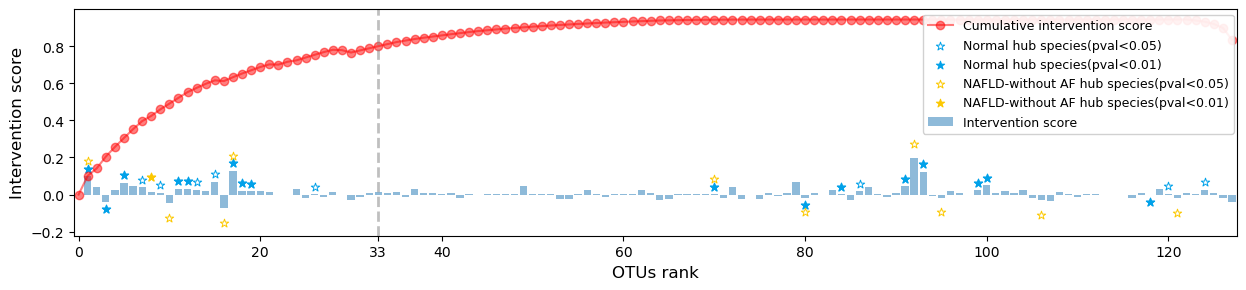

In [70]:
score_df = pd.read_csv(CAUSAL_PATH+'NonAF_IS.csv', index_col=0)
score_df.head(33)

_ = plt.figure(1, (15, 3), dpi=100)
_ = plt.bar(range(1, len(score_df.index)+1), score_df['IS'], label='Intervention score', alpha=0.5)
cis = [0]
cis.extend(score_df['CIS'])
_ = plt.plot(range(0, len(score_df.index)+1), cis, 'r-', marker='o', label='Cumulative intervention score', alpha=0.5)

# '#00a1e9' # 蓝色 '#ea5550' # 红色 '#fcc800' # 黄色
Normal_keystone = np.array([i for i in range(len(score_df.index)) if list(score_df['normal_hits_pval'])[i]<=0.05])
y_loc = np.array(score_df['IS'])[Normal_keystone]
fdr001 = [True if i<=0.01 else False for i in np.array(score_df['normal_hits_pval'])[Normal_keystone]]
fdr001 = [i for i in range(len(fdr001)) if fdr001[i]]
_ = plt.scatter(Normal_keystone+1, y_loc+np.sign(y_loc)*0.04, marker='*', s=40,
                color='#00a1e9', facecolors='white', lw=0.7, label='Normal hub species(pval<0.05)')
_ = plt.scatter(Normal_keystone[fdr001]+1, y_loc[fdr001]+np.sign(y_loc[fdr001])*0.04, marker='*', s=40,
                color='#00a1e9', facecolors='#00a1e9', lw=0.7, label='Normal hub species(pval<0.01)')

NonAF_keystone = np.array([i for i in range(len(score_df.index)) if list(score_df['nonaf_hits_pval'])[i]<=0.05])
y_loc = np.array(score_df['IS'])[NonAF_keystone]
fdr001 = [True if i<=0.01 else False for i in np.array(score_df['nonaf_hits_pval'])[NonAF_keystone]]
fdr001 = [i for i in range(len(fdr001)) if fdr001[i]]
_ = plt.scatter(NonAF_keystone+1, y_loc+np.sign(y_loc)*0.08, marker='*', s=40,
                color='#fcc800', facecolors='white', lw=0.7, label='NAFLD-without AF hub species(pval<0.05)')
_ = plt.scatter(NonAF_keystone[fdr001]+1, y_loc[fdr001]+np.sign(y_loc[fdr001])*0.08, marker='*', s=40,
                color='#fcc800', facecolors='#fcc800', lw=0.7, label='NAFLD-without AF hub species(pval<0.01)')

_ = plt.xlabel('OTUs rank',fontsize=12)
_ = plt.ylabel('Intervention score',fontsize=12)
_ = plt.axvline(33.0, alpha=0.5, color='gray', linestyle='--', lw=2)
_ = plt.xlim([-0.5, 127.5])
_ = plt.xticks([0, 33, 20, 40, 60, 80, 100, 120])
_ = plt.legend(fontsize=9, loc = (0.73, 0.45), frameon=True, framealpha=0.9)    
_ = plt.show()

,Class,Family,Species,Abb.,normal_hits_score,normal_hits_pval,af_hits_score,af_hits_pval,normal_abun,af_abun,abun_pval,abun_fdr,normal_hits_rank,af_hits_rank,IS,CIS,Rank
OTU,,,,,,,,,,,,,,,,,
2f3327540661a5b628a103352e2d9731fb7bd13c,Clostridiales,Lachnospiraceae,Dorea formicigenerans,D. formicigenerans,0.040558,0.001,4.880254e-02,0.001,0.242775,0.348286,1.050733e-01,0.259655,86,86,0.168364,0.168364,1
3e5949b5957586cb373a4fc1ff516e0dc5811c44,Clostridiales,Lachnospiraceae,Hespellia porcina,H. porcina,0.048522,0.001,4.159244e-02,0.001,0.034827,0.061166,7.859775e-01,0.852776,77,77,0.060309,0.173488,2
16beeaa3ec13a7c9bebeddc43dddbbb389868ea2,Clostridiales,Family XIII,Family(OTU78),Family(OTU78),0.000503,0.998,3.733265e-02,0.001,0.068237,0.031591,2.295828e-02,0.115853,91,91,-0.014355,0.238127,3
46eaed43232c0befcbeaa88c2a78e346521b86c0,Clostridiales,Lachnospiraceae,Blautia sp. Marseille-P3087,B. sp. Marseille-P3087,0.024952,0.001,4.695354e-02,0.001,0.074920,0.152944,4.501205e-01,0.565993,59,59,0.049737,0.325935,4
5c3307470a80cc114615671dde3c6958e3de89de,Clostridiales,Lachnospiraceae,Roseburia hominis(OTU106),R. hominis(OTU106),0.003053,0.941,1.539211e-03,0.944,0.475830,0.028396,5.106582e-03,0.068346,80,80,0.034362,0.383108,5
f6479b19f128dca30479850ac88ee680e77f5a7d,Clostridiales,Peptostreptococcaceae,Romboutsia lituseburensis,R. lituseburensis,0.018512,0.017,5.413774e-03,0.639,0.494134,0.053833,9.350760e-04,0.042506,40,40,0.049474,0.433536,6
dd04fe7034b9f803cd16f1d8755679574b681e38,Clostridiales,Lachnospiraceae,Eubacterium ramulus(OTU103),E. ramulus(OTU103),0.030758,0.001,0.000000e+00,1.000,0.119001,0.066873,2.774123e-01,0.404958,79,79,0.030758,0.464294,7
3ab368af55d977e3b60b558ae78e83f77bb5ae30,Clostridiales,Lachnospiraceae,Anaerostipes caccae,A. caccae,0.019620,0.006,7.508900e-04,0.983,1.528639,2.212083,6.106589e-01,0.711502,76,76,0.029462,0.493756,8
12821fc1962342d552c75c911fee8353f055070e,Clostridiales,Lachnospiraceae,Fusicatenibacter saccharivorans,F. saccharivorans,0.030952,0.001,4.104025e-03,0.770,1.261914,0.821408,6.312130e-02,0.203101,82,82,0.016691,0.496185,9


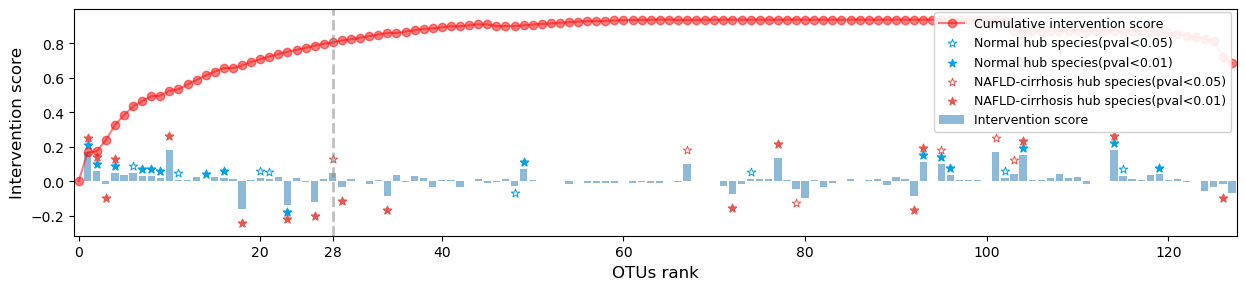

In [74]:
score_df = pd.read_csv(CAUSAL_PATH+'AF_IS.csv', index_col=0)
score_df.head(28)

_ = plt.figure(1, (15, 3), dpi=100)
_ = plt.bar(range(1, len(score_df.index)+1), score_df['IS'], label='Intervention score', alpha=0.5)
cis = [0]
cis.extend(score_df['CIS'])
_ = plt.plot(range(0, len(score_df.index)+1), cis, 'r-', marker='o', label='Cumulative intervention score', alpha=0.5)

# '#00a1e9' # 蓝色 '#ea5550' # 红色 '#fcc800' # 黄色
Normal_keystone = np.array([i for i in range(len(score_df.index)) if list(score_df['normal_hits_pval'])[i]<=0.05])
y_loc = np.array(score_df['IS'])[Normal_keystone]
fdr001 = [True if i<=0.01 else False for i in np.array(score_df['normal_hits_pval'])[Normal_keystone]]
fdr001 = [i for i in range(len(fdr001)) if fdr001[i]]
_ = plt.scatter(Normal_keystone+1, y_loc+np.sign(y_loc)*0.04, marker='*', s=40,
                color='#00a1e9', facecolors='white', lw=0.7, label='Normal hub species(pval<0.05)')
_ = plt.scatter(Normal_keystone[fdr001]+1, y_loc[fdr001]+np.sign(y_loc[fdr001])*0.04, marker='*', s=40,
                color='#00a1e9', facecolors='#00a1e9', lw=0.7, label='Normal hub species(pval<0.01)')

AF_keystone = np.array([i for i in range(len(score_df.index)) if list(score_df['af_hits_pval'])[i]<=0.05])
y_loc = np.array(score_df['IS'])[AF_keystone]
fdr001 = [True if i<=0.01 else False for i in np.array(score_df['af_hits_pval'])[AF_keystone]]
fdr001 = [i for i in range(len(fdr001)) if fdr001[i]]
_ = plt.scatter(AF_keystone+1, y_loc+np.sign(y_loc)*0.08, marker='*', s=40,
                color='#ea5550', facecolors='white', lw=0.7, label='NAFLD-cirrhosis hub species(pval<0.05)')
_ = plt.scatter(AF_keystone[fdr001]+1, y_loc[fdr001]+np.sign(y_loc[fdr001])*0.08, marker='*', s=40,
                color='#ea5550', facecolors='#ea5550', lw=0.7, label='NAFLD-cirrhosis hub species(pval<0.01)')

_ = plt.xlabel('OTUs rank',fontsize=12)
_ = plt.ylabel('Intervention score',fontsize=12)
_ = plt.axvline(28.0, alpha=0.5, color='gray', linestyle='--', lw=2)
_ = plt.xlim([-0.5, 127.5])
_ = plt.xticks([0, 28, 20, 40, 60, 80, 100, 120])
_ = plt.legend(fontsize=9, loc = (0.74, 0.46), frameon=True, framealpha=0.9)    
_ = plt.show()

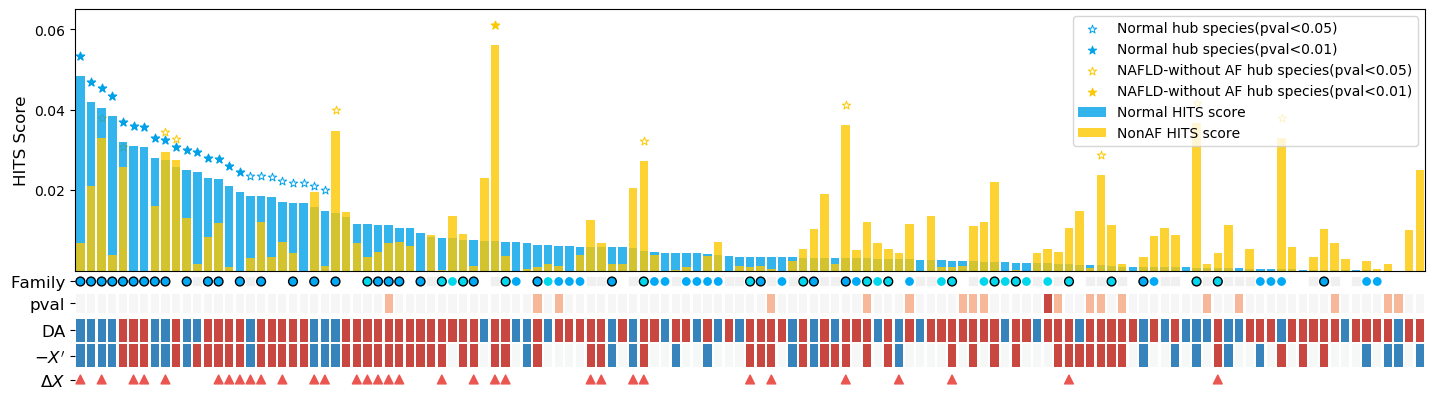

In [76]:
NonAF_IS = pd.read_csv(CAUSAL_PATH+'NonAF_IS.csv', index_col=0)

A = adjacency_matrix('NonAF')
OTUs = list(A.columns)
inventions = np.zeros(len(OTUs))
from_abun = abun_df.loc[DiseaseStatus=='NonAF', OTUs].mean()
to_abun = abun_df.loc[DiseaseStatus=='Normal', OTUs].mean()
for otu in list(NonAF_IS.index)[:33]:
    inventions[OTUs.index(otu)] = to_abun.loc[otu] - from_abun.loc[otu]
dx = get_delta_X(A, inventions, from_abun, decay=0.0, max_iter=100)
dx = pd.DataFrame(np.array([dx]).T, columns=['DX'], index=OTUs)

########### Plot ###########
dx_df = copy.deepcopy(NonAF_IS)
dx_df = dx_df.sort_values('normal_hits_score', ascending=False)
dx_df['Diff'] = np.sign(dx_df['nonaf_abun'] - dx_df['normal_abun'])
dx_df['-Delta X'] = -np.sign([dx.loc[i, 'DX'] for i in dx_df.index])
dx_df['Index'] = range(len(dx_df.index))

_ = plt.figure(figsize=(15, 5), dpi=100)
gs = gridspec.GridSpec(5, 1, height_ratios=[0.72, 0.04, 0.06, 0.14, 0.04])
gs.update(left=0.05, right=0.95, wspace=0.05, hspace=0.05)

# '#00a1e9' # 蓝色 '#ea5550' # 红色 '#fcc800' # 黄色
ax = plt.subplot(gs[0, 0])
_ = plt.bar(dx_df.index, dx_df['normal_hits_score'], label='Normal HITS score', alpha=0.8, color='#00a1e9')
_ = plt.bar(dx_df.index, dx_df['nonaf_hits_score'], label='NonAF HITS score', alpha=0.8, color='#fcc800')

x = np.array([i for i in dx_df.index if dx_df.loc[i, 'normal_hits_pval']<=0.05])
fdr001 = [True if i<=0.01 else False for i in dx_df.loc[x, 'normal_hits_pval']]
fdr001 = [i for i in range(len(fdr001)) if fdr001[i]]
y = dx_df.loc[x, 'normal_hits_score']+0.005
_ = plt.scatter(x, y, marker='*', s=40, color='#00a1e9', facecolors='white', lw=0.7,
                label='Normal hub species(pval<0.05)')
_ = plt.scatter(x[fdr001], y[fdr001], marker='*', s=40, color='#00a1e9', facecolors='#00a1e9', lw=0.7,
                label='Normal hub species(pval<0.01)')

x = np.array([i for i in dx_df.index if dx_df.loc[i, 'nonaf_hits_pval']<=0.05])
fdr001 = [True if i<=0.01 else False for i in dx_df.loc[x, 'nonaf_hits_pval']]
fdr001 = [i for i in range(len(fdr001)) if fdr001[i]]
y = dx_df.loc[x, 'nonaf_hits_score']+0.005
_ = plt.scatter(x, y, marker='*', s=40, color='#fcc800', facecolors='white', lw=0.7,
                label='NAFLD-without AF hub species(pval<0.05)')
_ = plt.scatter(x[fdr001], y[fdr001], marker='*', s=40, color='#fcc800', facecolors='#fcc800', lw=0.7,
                label='NAFLD-without AF hub species(pval<0.01)')

_ = plt.xlim([-0.5, len(dx_df.index)-0.5])
_ = plt.xticks([])
_ = plt.yticks([0.02, 0.04, 0.06])
_ = plt.ylabel('HITS Score', fontsize=12)
_ = plt.legend(fontsize=10, loc='upper right')

#############
colors = {'Family XI':'#006dd6', 'Lachnospiraceae':'#00a9f5', 'Ruminococcaceae':'#00d6ec',
         'Peptostreptococcaceae':'#a1e3f5', 'Family XIII':'#a4fbfb', 'Bacteroidaceae':'#ff0000',
         'Prevotellaceae':'#ff5700', 'Rikenellaceae':'#ff9093', 'Marinifilaceae':'#ff64b9',
         'Porphyromonadaceae':'#ffabd5', 'Tannerellaceae':'#ffdadb', 'Leuconostocaceae':'#31c000',
         'Streptococcaceae':'#a0ef6c', 'Veillonellaceae':'#ffc200', 'Burkholderiaceae':'#ff00ff',
         'Bifidobacteriaceae':'#de76de', 'Enterobacteriaceae':'#eda5ff', 'Campylobacteraceae':'#f6c9f6',
         'Desulfovibrionaceae':'#ffd5ff'}
ax = plt.subplot(gs[1, 0])
color = [colors.get(dx_df.loc[i, 'Family'], '#f0f0f0') for i in dx_df.index]
for f in colors.keys():
    sub_df = dx_df.loc[dx_df['Family']==f, :]
    lw = [1 if sub_df.loc[i, 'Diff']==sub_df.loc[i, '-Delta X'] else 0 for i in sub_df.index]
    if f == 'Lachnospiraceae':
        _ = plt.scatter(sub_df['Index'], [0 for i in sub_df.index], marker='o', s=40,
                        color=colors[f], lw=lw, edgecolors='black')
    elif f == 'Ruminococcaceae':
        _ = plt.scatter(sub_df['Index'], [0 for i in sub_df.index], marker='o', s=40,
                        color=colors[f], lw=lw, edgecolors='black')
    else:
        _ = plt.scatter(sub_df['Index'], [0 for i in sub_df.index], marker='s', s=40, color='#f0f0f0')
#_ = plt.scatter(dx_df.index, [0 for i in dx_df.index], marker='s', s=60, color=color)

_ = plt.xlim([-0.5, len(dx_df.index)-0.5])
_ = plt.xticks([])
_ = plt.yticks([0], ['Family'], fontsize=12)
_ = ax.spines['top'].set_visible(False)
_ = ax.spines['right'].set_visible(False)
_ = ax.spines['bottom'].set_visible(False)
_ = ax.spines['left'].set_visible(False)
#############

ax = plt.subplot(gs[2, 0])
heatmap_data = np.array([[1 if i<0.01 else (0.5 if i<=0.05 else 0) for i in dx_df['abun_pval']]])
hp = sns.heatmap(heatmap_data, vmin=-1, vmax=1, linewidths=1, cmap=sns.color_palette("RdBu_r", n_colors=5), cbar=False)
_ = hp.set_xticks([])
_ = hp.set_yticklabels(['pval'], rotation=360, fontsize=12)

ax = plt.subplot(gs[3, 0])
heatmap_data = dx_df.loc[:, ['Diff', '-Delta X']].T
heatmap_data.columns = range(len(heatmap_data.columns))
hp = sns.heatmap(heatmap_data, vmin=-1, vmax=1, linewidths=1, cmap=sns.color_palette("RdBu", n_colors=5), cbar=False)
_ = hp.set_yticklabels(['DA', "$-X'$"], rotation=360, fontsize=12)
_ = hp.set_xticks([])

ax = plt.subplot(gs[4, 0])
s = [40 if i in list(NonAF_IS.index)[:33] else 0 for i in dx_df.index]
_ = plt.scatter(dx_df.index, [0 for i in dx_df.index], marker='^', s=s, color='#ea5550')
#x = np.array([list(dx_df.index).index(otu) for otu in list(NASH_IS.index)[:8]])
#_ = plt.scatter(x, [0 for i in x], marker='^', color='#ea5550')
_ = plt.xlim([-0.5, len(dx_df.index)-0.5])
_ = plt.xticks([])
_ = plt.yticks([0], ['$\Delta X$'], fontsize=12)
_ = ax.spines['top'].set_visible(False)
_ = ax.spines['right'].set_visible(False)
_ = ax.spines['bottom'].set_visible(False)
_ = ax.spines['left'].set_visible(False)

plt.show()

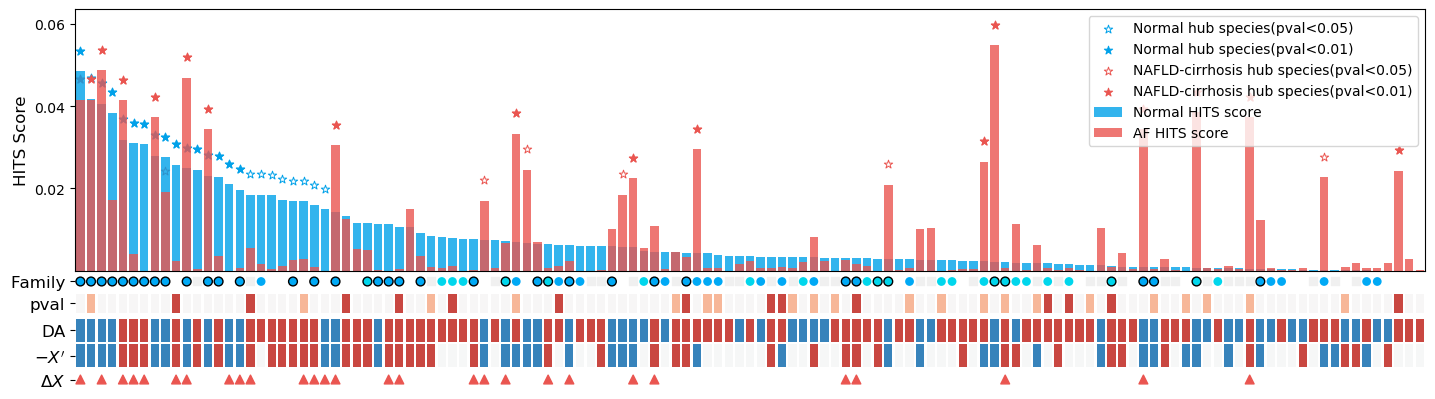

In [77]:
AF_IS = pd.read_csv(CAUSAL_PATH+'AF_IS.csv', index_col=0)

A = adjacency_matrix('AF')
OTUs = list(A.columns)
inventions = np.zeros(len(OTUs))
from_abun = abun_df.loc[DiseaseStatus=='AF', OTUs].mean()
to_abun = abun_df.loc[DiseaseStatus=='Normal', OTUs].mean()
for otu in list(AF_IS.index)[:28]:
    inventions[OTUs.index(otu)] = to_abun.loc[otu] - from_abun.loc[otu]
dx = get_delta_X(A, inventions, from_abun, decay=0.0, max_iter=100)
dx = pd.DataFrame(np.array([dx]).T, columns=['DX'], index=OTUs)

########### Plot ###########
dx_df = copy.deepcopy(AF_IS)
dx_df = dx_df.sort_values('normal_hits_score', ascending=False)
dx_df['Diff'] = np.sign(dx_df['af_abun'] - dx_df['normal_abun'])
dx_df['-Delta X'] = -np.sign([dx.loc[i, 'DX'] for i in dx_df.index])
dx_df['Index'] = range(len(dx_df.index))

_ = plt.figure(figsize=(15, 5), dpi=100)
gs = gridspec.GridSpec(5, 1, height_ratios=[0.72, 0.04, 0.06, 0.14, 0.04])
gs.update(left=0.05, right=0.95, wspace=0.05, hspace=0.05)

# '#00a1e9' # 蓝色 '#ea5550' # 红色 '#fcc800' # 黄色
ax = plt.subplot(gs[0, 0])
_ = plt.bar(dx_df.index, dx_df['normal_hits_score'], label='Normal HITS score', alpha=0.8, color='#00a1e9')
_ = plt.bar(dx_df.index, dx_df['af_hits_score'], label='AF HITS score', alpha=0.8, color='#ea5550')

x = np.array([i for i in dx_df.index if dx_df.loc[i, 'normal_hits_pval']<=0.05])
fdr001 = [True if i<=0.01 else False for i in dx_df.loc[x, 'normal_hits_pval']]
fdr001 = [i for i in range(len(fdr001)) if fdr001[i]]
y = dx_df.loc[x, 'normal_hits_score']+0.005
_ = plt.scatter(x, y, marker='*', s=40, color='#00a1e9', facecolors='white', lw=0.7,
                label='Normal hub species(pval<0.05)')
_ = plt.scatter(x[fdr001], y[fdr001], marker='*', s=40, color='#00a1e9', facecolors='#00a1e9', lw=0.7,
                label='Normal hub species(pval<0.01)')

x = np.array([i for i in dx_df.index if dx_df.loc[i, 'af_hits_pval']<=0.05])
fdr001 = [True if i<=0.01 else False for i in dx_df.loc[x, 'af_hits_pval']]
fdr001 = [i for i in range(len(fdr001)) if fdr001[i]]
y = dx_df.loc[x, 'af_hits_score']+0.005
_ = plt.scatter(x, y, marker='*', s=40, color='#ea5550', facecolors='white', lw=0.7,
                label='NAFLD-cirrhosis hub species(pval<0.05)')
_ = plt.scatter(x[fdr001], y[fdr001], marker='*', s=40, color='#ea5550', facecolors='#ea5550', lw=0.7,
                label='NAFLD-cirrhosis hub species(pval<0.01)')

_ = plt.xlim([-0.5, len(dx_df.index)-0.5])
_ = plt.xticks([])
_ = plt.yticks([0.02, 0.04, 0.06])
_ = plt.ylabel('HITS Score', fontsize=12)
_ = plt.legend(fontsize=10, loc='upper right')

#############
colors = {'Family XI':'#006dd6', 'Lachnospiraceae':'#00a9f5', 'Ruminococcaceae':'#00d6ec',
         'Peptostreptococcaceae':'#a1e3f5', 'Family XIII':'#a4fbfb', 'Bacteroidaceae':'#ff0000',
         'Prevotellaceae':'#ff5700', 'Rikenellaceae':'#ff9093', 'Marinifilaceae':'#ff64b9',
         'Porphyromonadaceae':'#ffabd5', 'Tannerellaceae':'#ffdadb', 'Leuconostocaceae':'#31c000',
         'Streptococcaceae':'#a0ef6c', 'Veillonellaceae':'#ffc200', 'Burkholderiaceae':'#ff00ff',
         'Bifidobacteriaceae':'#de76de', 'Enterobacteriaceae':'#eda5ff', 'Campylobacteraceae':'#f6c9f6',
         'Desulfovibrionaceae':'#ffd5ff'}
ax = plt.subplot(gs[1, 0])
color = [colors.get(dx_df.loc[i, 'Family'], '#f0f0f0') for i in dx_df.index]
for f in colors.keys():
    sub_df = dx_df.loc[dx_df['Family']==f, :]
    lw = [1 if sub_df.loc[i, 'Diff']==sub_df.loc[i, '-Delta X'] else 0 for i in sub_df.index]
    if f == 'Lachnospiraceae':
        _ = plt.scatter(sub_df['Index'], [0 for i in sub_df.index], marker='o', s=40,
                        color=colors[f], lw=lw, edgecolors='black')
    elif f == 'Ruminococcaceae':
        _ = plt.scatter(sub_df['Index'], [0 for i in sub_df.index], marker='o', s=40,
                        color=colors[f], lw=lw, edgecolors='black')
    else:
        _ = plt.scatter(sub_df['Index'], [0 for i in sub_df.index], marker='s', s=40, color='#f0f0f0')
#_ = plt.scatter(dx_df.index, [0 for i in dx_df.index], marker='s', s=60, color=color)

_ = plt.xlim([-0.5, len(dx_df.index)-0.5])
_ = plt.xticks([])
_ = plt.yticks([0], ['Family'], fontsize=12)
_ = ax.spines['top'].set_visible(False)
_ = ax.spines['right'].set_visible(False)
_ = ax.spines['bottom'].set_visible(False)
_ = ax.spines['left'].set_visible(False)
#############

ax = plt.subplot(gs[2, 0])
heatmap_data = np.array([[1 if i<0.01 else (0.5 if i<=0.05 else 0) for i in dx_df['abun_pval']]])
hp = sns.heatmap(heatmap_data, vmin=-1, vmax=1, linewidths=1, cmap=sns.color_palette("RdBu_r", n_colors=5), cbar=False)
_ = hp.set_xticks([])
_ = hp.set_yticklabels(['pval'], rotation=360, fontsize=12)

ax = plt.subplot(gs[3, 0])
heatmap_data = dx_df.loc[:, ['Diff', '-Delta X']].T
heatmap_data.columns = range(len(heatmap_data.columns))
hp = sns.heatmap(heatmap_data, vmin=-1, vmax=1, linewidths=1, cmap=sns.color_palette("RdBu", n_colors=5), cbar=False)
_ = hp.set_yticklabels(['DA', "$-X'$"], rotation=360, fontsize=12)
_ = hp.set_xticks([])

ax = plt.subplot(gs[4, 0])
s = [40 if i in list(AF_IS.index)[:28] else 0 for i in dx_df.index]
_ = plt.scatter(dx_df.index, [0 for i in dx_df.index], marker='^', s=s, color='#ea5550')
#x = np.array([list(dx_df.index).index(otu) for otu in list(NASH_IS.index)[:8]])
#_ = plt.scatter(x, [0 for i in x], marker='^', color='#ea5550')
_ = plt.xlim([-0.5, len(dx_df.index)-0.5])
_ = plt.xticks([])
_ = plt.yticks([0], ['$\Delta X$'], fontsize=12)
_ = ax.spines['top'].set_visible(False)
_ = ax.spines['right'].set_visible(False)
_ = ax.spines['bottom'].set_visible(False)
_ = ax.spines['left'].set_visible(False)

plt.show()

#### Normal中HITS排名前40个菌种干预效果

Diff: Normal到NASH菌种丰度变化；-Delta X：NASH状态中，菌种干预后的丰度变化 (为了明显比较丰度变化，取了负值)；红色丰度升高，蓝色丰度下降；

Normal网络中最重要的40个菌种在干预后，能够将NASH中失衡的菌种朝Normal状态丰度进行调节，但干预效果并没有青少年好；

#### Normal HITS前12菌种展示

* 前40个高效干预菌种主要属于梭菌目（Clostridiales）中的毛螺菌科（Lachnospiraceae）和Ruminococcaceae等；此外，还包括Erysipelotrichaceae，Peptostreptococcaceae，Eggerthellaceae，Enterococcaceae，Christensenellaceae，Akkermansiaceae等；
* 其中，Agathobacter，Faecalibacterium，Bacteroides，Blautia，Anaerostipes等属在青少年NASH干预中同样重要；Agathobacter是青少年中最主要的关键干预菌种，需要对疾病状态的该菌种丰度进行上调干预，在成年人中该属的菌种同样在疾病中丰度下降，同样需要进行补充干预；
* 像 Eubacterium hallii，它是人体年龄的变化的一个重要标志菌，随年龄增加而增加，因此在成年人中相对重要《Human microbiome aging clocks based on deep learning and tandem of permutation feature importance and accumulated local effects》；

#### 40个高效干预菌种的丰度和样本分辨能力

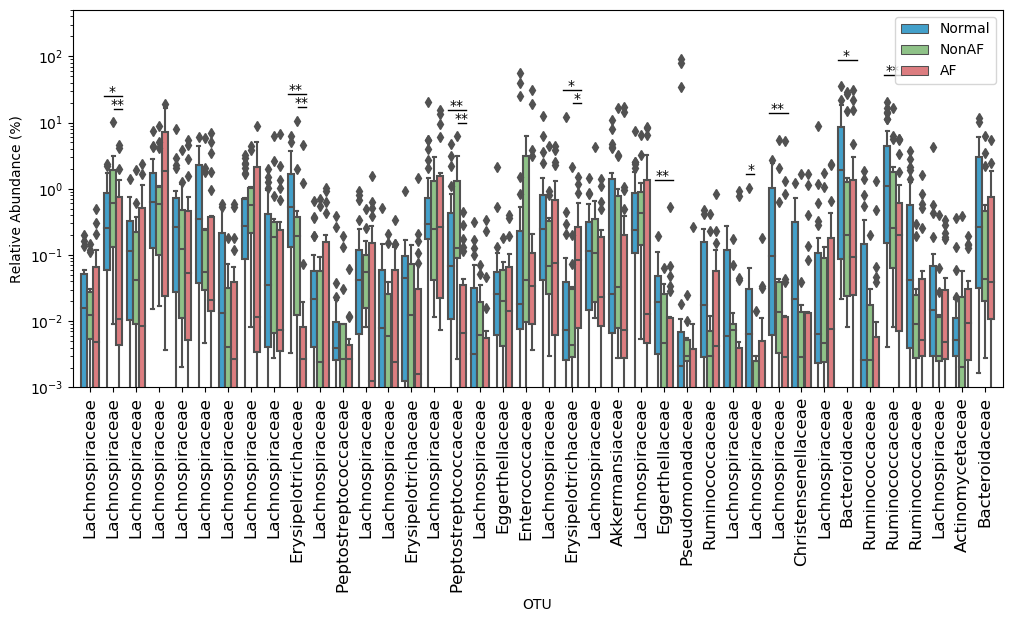

In [102]:
DEOTU = Normal_HITS['OTU'][:40]
res_plot = []
for otu in DEOTU:
    for d in ['Normal', 'NonAF', 'AF']:
        for i in abun_df.loc[DiseaseStatus==d, otu]:
            res_plot.append([otu, tax_df.loc[otu, 'Taxon'], d, i])
res_plot = pd.DataFrame(res_plot, columns=['OTU', 'Taxon', 'State', 'Abundance'])
_ = plt.figure(figsize=(12, 5), dpi=100)
p = sns.boxplot(x="OTU", y="Abundance", hue="State", data=res_plot, palette=['#2ca9e1', '#88cb7f', '#ec6d71'])
######
import matplotlib.lines as mlines
i = 0
for otu in DEOTU:
    max_value = res_plot.loc[res_plot['OTU']==otu, 'Abundance'].max()
    if NonAF_vs_Normal.loc[otu, 'p-value']<=0.05:
        x, y = np.array([[i-0.4, i-0.05], [max_value*1.6, max_value*1.6]])
        l = mlines.Line2D(x, y, lw=1., c='k')
        _ = p.add_line(l)
        _ = plt.text(i-0.2, max_value*1.6, '**' if NonAF_vs_Normal.loc[otu, 'p-value']<=0.01 else '*',
                     ha="center", size=10)
        
    if AF_vs_NonAF.loc[otu, 'p-value']<=0.05:
        x, y = np.array([[i+0.05, i+0.4], [max_value*1.6, max_value*1.6]])
        l = mlines.Line2D(x, y, lw=1., c='k')
        _ = p.add_line(l)
        _ = plt.text(i+0.2, max_value*1.6, '**' if AF_vs_NonAF.loc[otu, 'p-value']<=0.01 else '*',
                     ha="center", size=10)
        
    if AF_vs_Normal.loc[otu, 'p-value']<=0.05:
        x, y = np.array([[i-0.4, i+0.4], [max_value*2.5, max_value*2.5]])
        l = mlines.Line2D(x, y, lw=1., c='k')
        _ = p.add_line(l)
        _ = plt.text(i-0.05, max_value*2.5, '**' if AF_vs_Normal.loc[otu, 'p-value']<=0.01 else '*',
                     ha="center", size=10)
    i += 1  
#######   
_ = plt.ylim([10**(-3), 500])
_ = plt.semilogy()
_ = plt.xticks(range(len(DEOTU)), [tax_df.loc[otu, 'Taxon'].split('D_4__')[1].split(';D_5__')[0] for otu in DEOTU], rotation=90, fontsize=12)
_ = plt.legend(loc='upper right')
_ = plt.ylabel('Relative Abundance (%)')
_ = plt.show()

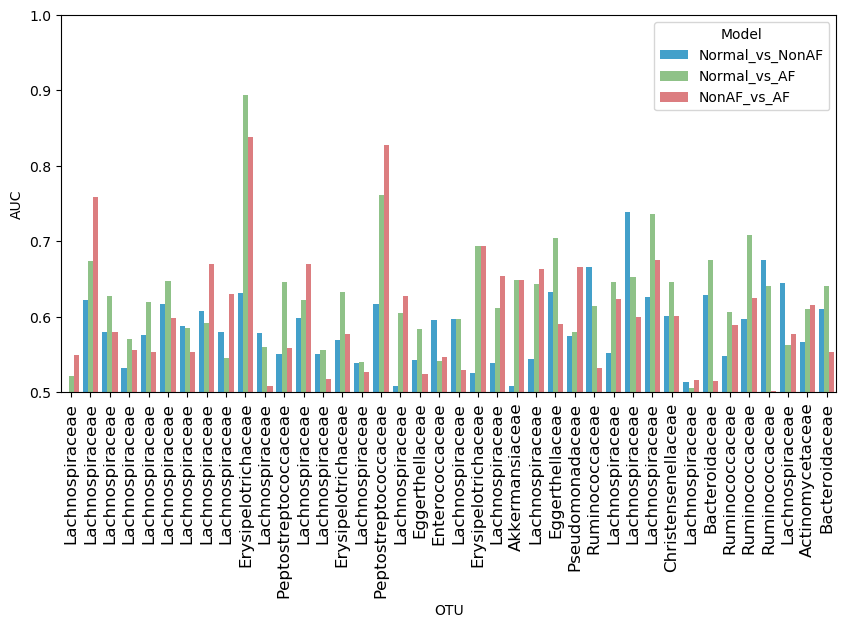

In [105]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
DEOTU = Normal_HITS['OTU'][:40]
dieases = DiseaseStatus
res = []
for otu in DEOTU:
    # Normal vs Obese
    X = abun_df.loc[dieases!='AF', otu]
    y = (dieases[dieases!='AF']=='NonAF')+0
    auc1 = max([roc_auc_score(y, X), roc_auc_score(y, -X)])
    res.append([otu, tax_df.loc[otu, 'Taxon'], 'Normal_vs_NonAF', auc1])
    # Normal vs NASH
    X = abun_df.loc[dieases!='NonAF', otu]
    y = (dieases[dieases!='NonAF']=='AF')+0
    auc2 = max([roc_auc_score(y, X), roc_auc_score(y, -X)])
    res.append([otu, tax_df.loc[otu, 'Taxon'], 'Normal_vs_AF', auc2])
    # Obese vs NASH
    X = abun_df.loc[dieases!='Normal', otu]
    y = (dieases[dieases!='Normal']=='AF')+0
    auc3 = max([roc_auc_score(y, X), roc_auc_score(y, -X)])
    res.append([otu, tax_df.loc[otu, 'Taxon'], 'NonAF_vs_AF', auc3])
    #print(otu, auc1, auc2, auc3)
res = pd.DataFrame(res, columns=['OTU', 'Tax', 'Model', 'AUC'])

_ = plt.figure(figsize=(10, 5), dpi=100)
_ = sns.barplot(x="OTU", y="AUC", hue="Model", data=res, palette=['#2ca9e1', '#88cb7f', '#ec6d71'])
_ = plt.ylim((0.5, 1))
_ = plt.xticks(range(len(DEOTU)), [tax_df.loc[otu, 'Taxon'].split('D_4__')[1].split(';D_5__')[0] for otu in DEOTU], rotation=90, fontsize=12)

* 和青少年中类似的，高效的干预菌种并不一定都是显著差异的菌种，其中只有少数几个丰度具有显著差异；
* 成年人中疾病状态的菌种主要呈现丰度下降趋势，因此干预应该以补充菌种为主；
* Erysipelotrichaceae是一个重要的NASH标志和干预靶标，能够区分正常和NonAF，同时能够区分NonAF和AF(cirrhosis)；《Rohit原文》中，该菌也是预测NAFLD-cirrhosis的重要指标；
* 研究表明，Erysipelotrichaceae(Allobaculum)在HFD喂养的前8周小鼠体内保持低丰度，仅在动物发生肥胖和胰岛素抵抗的第12周显着增加，(该菌种增加，我们数据中，该菌有增加也有减少，上图中分辨能力最强的该属菌种是丰度减少的)《ISME Structural resilience of the gut microbiota in adult mice under high-fat dietary perturbations》；虽然变化方向不同，但也说明，Erysipelotrichaceae菌种与疾病的变化胰岛素抵抗或者硬化有关系；